In [5]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [7]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # vanilla Backprop
#         dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [8]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3335, acc-0.0200, valid loss-2.3323, acc-0.0604, test loss-2.3323, acc-0.0637
Iter-20, train loss-2.3206, acc-0.0400, valid loss-2.3297, acc-0.0636, test loss-2.3295, acc-0.0660
Iter-30, train loss-2.3172, acc-0.0400, valid loss-2.3269, acc-0.0664, test loss-2.3267, acc-0.0679
Iter-40, train loss-2.3234, acc-0.0800, valid loss-2.3241, acc-0.0690, test loss-2.3237, acc-0.0708
Iter-50, train loss-2.3217, acc-0.0600, valid loss-2.3214, acc-0.0708, test loss-2.3210, acc-0.0733
Iter-60, train loss-2.3392, acc-0.0400, valid loss-2.3184, acc-0.0728, test loss-2.3179, acc-0.0768
Iter-70, train loss-2.3430, acc-0.0000, valid loss-2.3158, acc-0.0756, test loss-2.3151, acc-0.0796
Iter-80, train loss-2.3152, acc-0.0800, valid loss-2.3130, acc-0.0780, test loss-2.3122, acc-0.0833
Iter-90, train loss-2.2648, acc-0.2200, valid loss-2.3103, acc-0.0810, test loss-2.3093, acc-0.0860
Iter-100, train loss-2.3023, acc-0.0800, valid loss-2.3075, acc-0.0842, test loss-2.3065, acc-0.0888

Iter-830, train loss-2.1227, acc-0.4600, valid loss-2.1180, acc-0.4524, test loss-2.1101, acc-0.4733
Iter-840, train loss-2.1561, acc-0.4000, valid loss-2.1156, acc-0.4560, test loss-2.1076, acc-0.4750
Iter-850, train loss-2.0905, acc-0.5000, valid loss-2.1130, acc-0.4588, test loss-2.1049, acc-0.4776
Iter-860, train loss-2.0961, acc-0.5400, valid loss-2.1106, acc-0.4620, test loss-2.1024, acc-0.4798
Iter-870, train loss-2.1269, acc-0.4400, valid loss-2.1080, acc-0.4652, test loss-2.0998, acc-0.4825
Iter-880, train loss-2.1107, acc-0.4400, valid loss-2.1053, acc-0.4694, test loss-2.0971, acc-0.4846
Iter-890, train loss-2.0969, acc-0.4400, valid loss-2.1028, acc-0.4710, test loss-2.0944, acc-0.4863
Iter-900, train loss-2.1438, acc-0.3400, valid loss-2.1003, acc-0.4726, test loss-2.0918, acc-0.4886
Iter-910, train loss-2.1117, acc-0.4000, valid loss-2.0978, acc-0.4762, test loss-2.0892, acc-0.4910
Iter-920, train loss-2.0459, acc-0.5800, valid loss-2.0952, acc-0.4786, test loss-2.0865, a

Iter-1640, train loss-1.8841, acc-0.5200, valid loss-1.9098, acc-0.5520, test loss-1.8973, acc-0.5595
Iter-1650, train loss-1.9266, acc-0.5000, valid loss-1.9072, acc-0.5518, test loss-1.8947, acc-0.5604
Iter-1660, train loss-1.8779, acc-0.5600, valid loss-1.9046, acc-0.5524, test loss-1.8921, acc-0.5606
Iter-1670, train loss-1.8591, acc-0.5600, valid loss-1.9020, acc-0.5530, test loss-1.8894, acc-0.5616
Iter-1680, train loss-1.8794, acc-0.5800, valid loss-1.8995, acc-0.5534, test loss-1.8868, acc-0.5619
Iter-1690, train loss-1.9121, acc-0.5600, valid loss-1.8969, acc-0.5540, test loss-1.8843, acc-0.5617
Iter-1700, train loss-1.8353, acc-0.6600, valid loss-1.8943, acc-0.5546, test loss-1.8816, acc-0.5621
Iter-1710, train loss-1.8670, acc-0.5400, valid loss-1.8917, acc-0.5556, test loss-1.8790, acc-0.5625
Iter-1720, train loss-1.9212, acc-0.4800, valid loss-1.8890, acc-0.5556, test loss-1.8764, acc-0.5625
Iter-1730, train loss-1.8935, acc-0.5800, valid loss-1.8865, acc-0.5550, test loss

Iter-2450, train loss-1.5900, acc-0.7600, valid loss-1.7059, acc-0.5902, test loss-1.6928, acc-0.5900
Iter-2460, train loss-1.6409, acc-0.5600, valid loss-1.7035, acc-0.5902, test loss-1.6904, acc-0.5903
Iter-2470, train loss-1.5804, acc-0.7000, valid loss-1.7009, acc-0.5906, test loss-1.6879, acc-0.5903
Iter-2480, train loss-1.6069, acc-0.6400, valid loss-1.6985, acc-0.5912, test loss-1.6855, acc-0.5910
Iter-2490, train loss-1.7498, acc-0.6200, valid loss-1.6961, acc-0.5914, test loss-1.6830, acc-0.5913
Iter-2500, train loss-1.6146, acc-0.6800, valid loss-1.6936, acc-0.5918, test loss-1.6805, acc-0.5921
Iter-2510, train loss-1.6685, acc-0.6200, valid loss-1.6912, acc-0.5922, test loss-1.6782, acc-0.5924
Iter-2520, train loss-1.7076, acc-0.6600, valid loss-1.6888, acc-0.5920, test loss-1.6758, acc-0.5926
Iter-2530, train loss-1.8082, acc-0.4600, valid loss-1.6864, acc-0.5930, test loss-1.6735, acc-0.5929
Iter-2540, train loss-1.6322, acc-0.6600, valid loss-1.6841, acc-0.5940, test loss

Iter-3260, train loss-1.7275, acc-0.4400, valid loss-1.5180, acc-0.6266, test loss-1.5064, acc-0.6297
Iter-3270, train loss-1.5686, acc-0.6000, valid loss-1.5158, acc-0.6272, test loss-1.5042, acc-0.6303
Iter-3280, train loss-1.5779, acc-0.6000, valid loss-1.5136, acc-0.6276, test loss-1.5020, acc-0.6308
Iter-3290, train loss-1.4903, acc-0.6400, valid loss-1.5114, acc-0.6274, test loss-1.4999, acc-0.6311
Iter-3300, train loss-1.5503, acc-0.6400, valid loss-1.5091, acc-0.6280, test loss-1.4977, acc-0.6319
Iter-3310, train loss-1.5779, acc-0.6000, valid loss-1.5070, acc-0.6280, test loss-1.4955, acc-0.6323
Iter-3320, train loss-1.3920, acc-0.7800, valid loss-1.5047, acc-0.6286, test loss-1.4933, acc-0.6324
Iter-3330, train loss-1.4855, acc-0.6400, valid loss-1.5026, acc-0.6292, test loss-1.4912, acc-0.6335
Iter-3340, train loss-1.4376, acc-0.7200, valid loss-1.5004, acc-0.6294, test loss-1.4890, acc-0.6340
Iter-3350, train loss-1.5851, acc-0.5200, valid loss-1.4982, acc-0.6298, test loss

Iter-4070, train loss-1.4391, acc-0.6800, valid loss-1.3479, acc-0.6684, test loss-1.3397, acc-0.6701
Iter-4080, train loss-1.3219, acc-0.6800, valid loss-1.3459, acc-0.6686, test loss-1.3377, acc-0.6701
Iter-4090, train loss-1.3097, acc-0.6600, valid loss-1.3438, acc-0.6704, test loss-1.3357, acc-0.6708
Iter-4100, train loss-1.3852, acc-0.6600, valid loss-1.3418, acc-0.6716, test loss-1.3338, acc-0.6713
Iter-4110, train loss-1.3552, acc-0.7000, valid loss-1.3398, acc-0.6724, test loss-1.3319, acc-0.6716
Iter-4120, train loss-1.1730, acc-0.8400, valid loss-1.3378, acc-0.6740, test loss-1.3298, acc-0.6726
Iter-4130, train loss-1.3122, acc-0.7000, valid loss-1.3357, acc-0.6740, test loss-1.3278, acc-0.6733
Iter-4140, train loss-1.3779, acc-0.6000, valid loss-1.3338, acc-0.6742, test loss-1.3260, acc-0.6739
Iter-4150, train loss-1.3885, acc-0.6600, valid loss-1.3318, acc-0.6756, test loss-1.3241, acc-0.6747
Iter-4160, train loss-1.1817, acc-0.7600, valid loss-1.3299, acc-0.6746, test loss

Iter-4880, train loss-1.1325, acc-0.8400, valid loss-1.2015, acc-0.7110, test loss-1.1970, acc-0.7081
Iter-4890, train loss-1.2825, acc-0.6400, valid loss-1.1998, acc-0.7114, test loss-1.1954, acc-0.7094
Iter-4900, train loss-1.3148, acc-0.5800, valid loss-1.1982, acc-0.7120, test loss-1.1938, acc-0.7098
Iter-4910, train loss-1.1392, acc-0.7000, valid loss-1.1966, acc-0.7122, test loss-1.1922, acc-0.7104
Iter-4920, train loss-1.1962, acc-0.7200, valid loss-1.1950, acc-0.7124, test loss-1.1906, acc-0.7103
Iter-4930, train loss-1.0835, acc-0.8200, valid loss-1.1933, acc-0.7122, test loss-1.1891, acc-0.7104
Iter-4940, train loss-1.1996, acc-0.7800, valid loss-1.1918, acc-0.7134, test loss-1.1876, acc-0.7113
Iter-4950, train loss-1.2066, acc-0.7200, valid loss-1.1901, acc-0.7136, test loss-1.1860, acc-0.7117
Iter-4960, train loss-1.1680, acc-0.7600, valid loss-1.1885, acc-0.7130, test loss-1.1844, acc-0.7121
Iter-4970, train loss-1.2363, acc-0.6400, valid loss-1.1869, acc-0.7138, test loss

Iter-5690, train loss-1.0496, acc-0.7800, valid loss-1.0803, acc-0.7380, test loss-1.0784, acc-0.7341
Iter-5700, train loss-0.9506, acc-0.7000, valid loss-1.0790, acc-0.7380, test loss-1.0771, acc-0.7349
Iter-5710, train loss-1.1183, acc-0.7600, valid loss-1.0776, acc-0.7376, test loss-1.0758, acc-0.7350
Iter-5720, train loss-1.0694, acc-0.7200, valid loss-1.0762, acc-0.7376, test loss-1.0744, acc-0.7351
Iter-5730, train loss-1.2053, acc-0.6000, valid loss-1.0748, acc-0.7386, test loss-1.0731, acc-0.7355
Iter-5740, train loss-1.1540, acc-0.7400, valid loss-1.0735, acc-0.7390, test loss-1.0718, acc-0.7355
Iter-5750, train loss-1.1419, acc-0.7000, valid loss-1.0722, acc-0.7386, test loss-1.0705, acc-0.7353
Iter-5760, train loss-1.0531, acc-0.7000, valid loss-1.0709, acc-0.7394, test loss-1.0692, acc-0.7354
Iter-5770, train loss-1.0437, acc-0.7400, valid loss-1.0696, acc-0.7396, test loss-1.0680, acc-0.7353
Iter-5780, train loss-1.2105, acc-0.5800, valid loss-1.0683, acc-0.7396, test loss

Iter-6500, train loss-1.1507, acc-0.6800, valid loss-0.9822, acc-0.7552, test loss-0.9825, acc-0.7566
Iter-6510, train loss-0.9644, acc-0.7800, valid loss-0.9811, acc-0.7556, test loss-0.9815, acc-0.7563
Iter-6520, train loss-0.9410, acc-0.7600, valid loss-0.9800, acc-0.7558, test loss-0.9804, acc-0.7566
Iter-6530, train loss-1.0327, acc-0.7200, valid loss-0.9791, acc-0.7562, test loss-0.9794, acc-0.7571
Iter-6540, train loss-0.9854, acc-0.6600, valid loss-0.9779, acc-0.7562, test loss-0.9783, acc-0.7573
Iter-6550, train loss-0.9511, acc-0.7800, valid loss-0.9769, acc-0.7562, test loss-0.9772, acc-0.7580
Iter-6560, train loss-0.9774, acc-0.7600, valid loss-0.9758, acc-0.7568, test loss-0.9762, acc-0.7584
Iter-6570, train loss-1.0198, acc-0.7600, valid loss-0.9748, acc-0.7566, test loss-0.9751, acc-0.7583
Iter-6580, train loss-1.1142, acc-0.6600, valid loss-0.9737, acc-0.7566, test loss-0.9741, acc-0.7582
Iter-6590, train loss-0.9623, acc-0.8200, valid loss-0.9726, acc-0.7562, test loss

Iter-7310, train loss-0.8082, acc-0.8000, valid loss-0.9019, acc-0.7786, test loss-0.9043, acc-0.7758
Iter-7320, train loss-0.9543, acc-0.7800, valid loss-0.9010, acc-0.7786, test loss-0.9034, acc-0.7761
Iter-7330, train loss-0.9370, acc-0.7000, valid loss-0.9001, acc-0.7786, test loss-0.9026, acc-0.7762
Iter-7340, train loss-0.9440, acc-0.7800, valid loss-0.8993, acc-0.7786, test loss-0.9017, acc-0.7765
Iter-7350, train loss-0.8749, acc-0.8000, valid loss-0.8984, acc-0.7790, test loss-0.9008, acc-0.7766
Iter-7360, train loss-1.2198, acc-0.5400, valid loss-0.8976, acc-0.7792, test loss-0.9000, acc-0.7768
Iter-7370, train loss-0.9288, acc-0.8000, valid loss-0.8967, acc-0.7790, test loss-0.8991, acc-0.7769
Iter-7380, train loss-0.8503, acc-0.8000, valid loss-0.8959, acc-0.7792, test loss-0.8983, acc-0.7771
Iter-7390, train loss-1.0225, acc-0.6400, valid loss-0.8950, acc-0.7798, test loss-0.8974, acc-0.7774
Iter-7400, train loss-1.0419, acc-0.7800, valid loss-0.8941, acc-0.7794, test loss

Iter-8120, train loss-0.9706, acc-0.7600, valid loss-0.8354, acc-0.7950, test loss-0.8392, acc-0.7913
Iter-8130, train loss-0.9167, acc-0.8200, valid loss-0.8347, acc-0.7952, test loss-0.8384, acc-0.7917
Iter-8140, train loss-0.8354, acc-0.8200, valid loss-0.8339, acc-0.7954, test loss-0.8377, acc-0.7918
Iter-8150, train loss-0.8279, acc-0.7000, valid loss-0.8331, acc-0.7956, test loss-0.8369, acc-0.7924
Iter-8160, train loss-0.9853, acc-0.7400, valid loss-0.8324, acc-0.7956, test loss-0.8361, acc-0.7926
Iter-8170, train loss-0.8520, acc-0.8600, valid loss-0.8316, acc-0.7954, test loss-0.8354, acc-0.7925
Iter-8180, train loss-0.7021, acc-0.8800, valid loss-0.8308, acc-0.7956, test loss-0.8347, acc-0.7926
Iter-8190, train loss-0.8138, acc-0.8400, valid loss-0.8302, acc-0.7958, test loss-0.8340, acc-0.7927
Iter-8200, train loss-0.9471, acc-0.7600, valid loss-0.8294, acc-0.7962, test loss-0.8333, acc-0.7932
Iter-8210, train loss-0.8535, acc-0.8000, valid loss-0.8287, acc-0.7962, test loss

Iter-8930, train loss-0.7971, acc-0.8200, valid loss-0.7800, acc-0.8096, test loss-0.7845, acc-0.8046
Iter-8940, train loss-0.9373, acc-0.7000, valid loss-0.7793, acc-0.8096, test loss-0.7840, acc-0.8046
Iter-8950, train loss-0.8324, acc-0.7800, valid loss-0.7787, acc-0.8098, test loss-0.7834, acc-0.8049
Iter-8960, train loss-0.7419, acc-0.8400, valid loss-0.7781, acc-0.8098, test loss-0.7828, acc-0.8048
Iter-8970, train loss-0.9221, acc-0.7200, valid loss-0.7775, acc-0.8096, test loss-0.7822, acc-0.8045
Iter-8980, train loss-0.8152, acc-0.8200, valid loss-0.7769, acc-0.8100, test loss-0.7816, acc-0.8047
Iter-8990, train loss-0.8533, acc-0.7200, valid loss-0.7763, acc-0.8100, test loss-0.7810, acc-0.8050
Iter-9000, train loss-0.7046, acc-0.8200, valid loss-0.7756, acc-0.8102, test loss-0.7804, acc-0.8054
Iter-9010, train loss-0.8421, acc-0.7800, valid loss-0.7750, acc-0.8104, test loss-0.7798, acc-0.8052
Iter-9020, train loss-1.0195, acc-0.6400, valid loss-0.7744, acc-0.8104, test loss

Iter-9740, train loss-0.8176, acc-0.7800, valid loss-0.7332, acc-0.8210, test loss-0.7387, acc-0.8140
Iter-9750, train loss-0.7251, acc-0.8200, valid loss-0.7326, acc-0.8214, test loss-0.7383, acc-0.8142
Iter-9760, train loss-0.6976, acc-0.8400, valid loss-0.7322, acc-0.8214, test loss-0.7378, acc-0.8140
Iter-9770, train loss-0.6698, acc-0.7800, valid loss-0.7316, acc-0.8216, test loss-0.7373, acc-0.8142
Iter-9780, train loss-0.6659, acc-0.9000, valid loss-0.7311, acc-0.8216, test loss-0.7367, acc-0.8143
Iter-9790, train loss-0.8535, acc-0.7200, valid loss-0.7305, acc-0.8224, test loss-0.7361, acc-0.8147
Iter-9800, train loss-0.7600, acc-0.8800, valid loss-0.7300, acc-0.8228, test loss-0.7356, acc-0.8147
Iter-9810, train loss-0.7628, acc-0.7800, valid loss-0.7294, acc-0.8230, test loss-0.7351, acc-0.8150
Iter-9820, train loss-0.8473, acc-0.8000, valid loss-0.7289, acc-0.8226, test loss-0.7346, acc-0.8151
Iter-9830, train loss-0.6342, acc-0.9000, valid loss-0.7283, acc-0.8224, test loss

Iter-10540, train loss-0.7417, acc-0.7800, valid loss-0.6935, acc-0.8316, test loss-0.6998, acc-0.8248
Iter-10550, train loss-0.5807, acc-0.9200, valid loss-0.6931, acc-0.8312, test loss-0.6994, acc-0.8248
Iter-10560, train loss-0.8093, acc-0.7000, valid loss-0.6926, acc-0.8316, test loss-0.6989, acc-0.8249
Iter-10570, train loss-0.7437, acc-0.8000, valid loss-0.6921, acc-0.8316, test loss-0.6985, acc-0.8249
Iter-10580, train loss-0.7909, acc-0.7800, valid loss-0.6917, acc-0.8316, test loss-0.6980, acc-0.8248
Iter-10590, train loss-0.7426, acc-0.8400, valid loss-0.6912, acc-0.8316, test loss-0.6976, acc-0.8250
Iter-10600, train loss-0.6651, acc-0.8400, valid loss-0.6908, acc-0.8314, test loss-0.6972, acc-0.8253
Iter-10610, train loss-0.6676, acc-0.8200, valid loss-0.6903, acc-0.8316, test loss-0.6968, acc-0.8253
Iter-10620, train loss-0.6380, acc-0.8200, valid loss-0.6899, acc-0.8316, test loss-0.6963, acc-0.8255
Iter-10630, train loss-0.6716, acc-0.8800, valid loss-0.6894, acc-0.8320,

Iter-11340, train loss-0.7332, acc-0.8400, valid loss-0.6592, acc-0.8390, test loss-0.6655, acc-0.8332
Iter-11350, train loss-0.4801, acc-0.9000, valid loss-0.6587, acc-0.8392, test loss-0.6651, acc-0.8333
Iter-11360, train loss-0.5975, acc-0.9000, valid loss-0.6583, acc-0.8386, test loss-0.6648, acc-0.8333
Iter-11370, train loss-0.6563, acc-0.8400, valid loss-0.6579, acc-0.8388, test loss-0.6643, acc-0.8334
Iter-11380, train loss-0.7367, acc-0.8000, valid loss-0.6576, acc-0.8394, test loss-0.6639, acc-0.8332
Iter-11390, train loss-0.7012, acc-0.7800, valid loss-0.6572, acc-0.8392, test loss-0.6635, acc-0.8334
Iter-11400, train loss-0.6638, acc-0.8600, valid loss-0.6568, acc-0.8396, test loss-0.6632, acc-0.8333
Iter-11410, train loss-0.6718, acc-0.8600, valid loss-0.6564, acc-0.8400, test loss-0.6628, acc-0.8331
Iter-11420, train loss-0.7143, acc-0.7800, valid loss-0.6560, acc-0.8402, test loss-0.6624, acc-0.8333
Iter-11430, train loss-0.7240, acc-0.7800, valid loss-0.6556, acc-0.8402,

Iter-12140, train loss-0.6039, acc-0.8600, valid loss-0.6289, acc-0.8462, test loss-0.6354, acc-0.8384
Iter-12150, train loss-0.5752, acc-0.8800, valid loss-0.6284, acc-0.8466, test loss-0.6350, acc-0.8381
Iter-12160, train loss-0.6771, acc-0.8200, valid loss-0.6280, acc-0.8472, test loss-0.6347, acc-0.8383
Iter-12170, train loss-0.7306, acc-0.7400, valid loss-0.6276, acc-0.8472, test loss-0.6344, acc-0.8383
Iter-12180, train loss-0.8162, acc-0.7600, valid loss-0.6273, acc-0.8472, test loss-0.6340, acc-0.8382
Iter-12190, train loss-0.6588, acc-0.7800, valid loss-0.6269, acc-0.8474, test loss-0.6337, acc-0.8382
Iter-12200, train loss-0.6132, acc-0.8000, valid loss-0.6266, acc-0.8474, test loss-0.6334, acc-0.8384
Iter-12210, train loss-0.6906, acc-0.8000, valid loss-0.6262, acc-0.8476, test loss-0.6330, acc-0.8388
Iter-12220, train loss-0.6016, acc-0.8600, valid loss-0.6259, acc-0.8472, test loss-0.6327, acc-0.8386
Iter-12230, train loss-0.6962, acc-0.8000, valid loss-0.6255, acc-0.8470,

Iter-12940, train loss-0.5298, acc-0.8800, valid loss-0.6015, acc-0.8502, test loss-0.6086, acc-0.8444
Iter-12950, train loss-0.7874, acc-0.9000, valid loss-0.6012, acc-0.8502, test loss-0.6082, acc-0.8447
Iter-12960, train loss-0.5175, acc-0.8800, valid loss-0.6009, acc-0.8506, test loss-0.6079, acc-0.8446
Iter-12970, train loss-0.4721, acc-0.8200, valid loss-0.6006, acc-0.8506, test loss-0.6076, acc-0.8451
Iter-12980, train loss-0.6414, acc-0.8400, valid loss-0.6002, acc-0.8504, test loss-0.6073, acc-0.8449
Iter-12990, train loss-0.6619, acc-0.7800, valid loss-0.5999, acc-0.8510, test loss-0.6069, acc-0.8454
Iter-13000, train loss-0.5354, acc-0.9000, valid loss-0.5996, acc-0.8508, test loss-0.6066, acc-0.8458
Iter-13010, train loss-0.5064, acc-0.8800, valid loss-0.5992, acc-0.8512, test loss-0.6063, acc-0.8459
Iter-13020, train loss-0.5124, acc-0.8400, valid loss-0.5989, acc-0.8510, test loss-0.6060, acc-0.8462
Iter-13030, train loss-0.7753, acc-0.7200, valid loss-0.5986, acc-0.8512,

Iter-13740, train loss-0.5551, acc-0.8800, valid loss-0.5772, acc-0.8574, test loss-0.5847, acc-0.8490
Iter-13750, train loss-0.6638, acc-0.8400, valid loss-0.5768, acc-0.8574, test loss-0.5844, acc-0.8488
Iter-13760, train loss-0.4607, acc-0.8800, valid loss-0.5766, acc-0.8576, test loss-0.5841, acc-0.8492
Iter-13770, train loss-0.8108, acc-0.7600, valid loss-0.5763, acc-0.8568, test loss-0.5838, acc-0.8491
Iter-13780, train loss-0.5825, acc-0.8200, valid loss-0.5760, acc-0.8570, test loss-0.5835, acc-0.8490
Iter-13790, train loss-0.6381, acc-0.7800, valid loss-0.5757, acc-0.8572, test loss-0.5831, acc-0.8494
Iter-13800, train loss-0.4717, acc-0.9000, valid loss-0.5755, acc-0.8574, test loss-0.5828, acc-0.8491
Iter-13810, train loss-0.4967, acc-0.8800, valid loss-0.5752, acc-0.8572, test loss-0.5825, acc-0.8494
Iter-13820, train loss-0.5820, acc-0.9000, valid loss-0.5749, acc-0.8574, test loss-0.5822, acc-0.8495
Iter-13830, train loss-0.6323, acc-0.8200, valid loss-0.5746, acc-0.8576,

Iter-14540, train loss-0.5023, acc-0.8800, valid loss-0.5551, acc-0.8640, test loss-0.5630, acc-0.8552
Iter-14550, train loss-0.5478, acc-0.9000, valid loss-0.5548, acc-0.8640, test loss-0.5627, acc-0.8553
Iter-14560, train loss-0.8305, acc-0.7800, valid loss-0.5545, acc-0.8640, test loss-0.5624, acc-0.8553
Iter-14570, train loss-0.6562, acc-0.8000, valid loss-0.5543, acc-0.8642, test loss-0.5621, acc-0.8553
Iter-14580, train loss-0.5209, acc-0.8400, valid loss-0.5540, acc-0.8644, test loss-0.5619, acc-0.8556
Iter-14590, train loss-0.7004, acc-0.7400, valid loss-0.5537, acc-0.8644, test loss-0.5615, acc-0.8557
Iter-14600, train loss-0.5082, acc-0.9000, valid loss-0.5534, acc-0.8642, test loss-0.5613, acc-0.8561
Iter-14610, train loss-0.6241, acc-0.8400, valid loss-0.5532, acc-0.8646, test loss-0.5610, acc-0.8558
Iter-14620, train loss-0.4587, acc-0.8800, valid loss-0.5529, acc-0.8644, test loss-0.5607, acc-0.8559
Iter-14630, train loss-0.6460, acc-0.8600, valid loss-0.5526, acc-0.8644,

Iter-15340, train loss-0.5915, acc-0.8400, valid loss-0.5349, acc-0.8700, test loss-0.5428, acc-0.8625
Iter-15350, train loss-0.6971, acc-0.8400, valid loss-0.5346, acc-0.8700, test loss-0.5426, acc-0.8626
Iter-15360, train loss-0.3691, acc-0.9400, valid loss-0.5344, acc-0.8700, test loss-0.5423, acc-0.8626
Iter-15370, train loss-0.5168, acc-0.9000, valid loss-0.5341, acc-0.8702, test loss-0.5421, acc-0.8628
Iter-15380, train loss-0.6813, acc-0.8200, valid loss-0.5339, acc-0.8708, test loss-0.5419, acc-0.8629
Iter-15390, train loss-0.5753, acc-0.8600, valid loss-0.5337, acc-0.8706, test loss-0.5416, acc-0.8633
Iter-15400, train loss-0.5696, acc-0.8800, valid loss-0.5334, acc-0.8708, test loss-0.5414, acc-0.8635
Iter-15410, train loss-0.4375, acc-0.9400, valid loss-0.5331, acc-0.8712, test loss-0.5412, acc-0.8637
Iter-15420, train loss-0.5162, acc-0.8600, valid loss-0.5329, acc-0.8714, test loss-0.5410, acc-0.8636
Iter-15430, train loss-0.6543, acc-0.8200, valid loss-0.5327, acc-0.8712,

Iter-16140, train loss-0.4461, acc-0.9400, valid loss-0.5161, acc-0.8734, test loss-0.5242, acc-0.8684
Iter-16150, train loss-0.5882, acc-0.8800, valid loss-0.5159, acc-0.8736, test loss-0.5239, acc-0.8685
Iter-16160, train loss-0.6096, acc-0.8600, valid loss-0.5157, acc-0.8734, test loss-0.5237, acc-0.8684
Iter-16170, train loss-0.6721, acc-0.8000, valid loss-0.5155, acc-0.8734, test loss-0.5235, acc-0.8685
Iter-16180, train loss-0.7064, acc-0.7400, valid loss-0.5153, acc-0.8734, test loss-0.5233, acc-0.8688
Iter-16190, train loss-0.4013, acc-0.9000, valid loss-0.5151, acc-0.8736, test loss-0.5231, acc-0.8692
Iter-16200, train loss-0.5684, acc-0.8000, valid loss-0.5149, acc-0.8732, test loss-0.5228, acc-0.8691
Iter-16210, train loss-0.4907, acc-0.8400, valid loss-0.5146, acc-0.8738, test loss-0.5226, acc-0.8691
Iter-16220, train loss-0.8340, acc-0.7800, valid loss-0.5144, acc-0.8738, test loss-0.5223, acc-0.8691
Iter-16230, train loss-0.5352, acc-0.8400, valid loss-0.5142, acc-0.8736,

Iter-16940, train loss-0.5138, acc-0.9000, valid loss-0.4998, acc-0.8772, test loss-0.5077, acc-0.8730
Iter-16950, train loss-0.5112, acc-0.8800, valid loss-0.4996, acc-0.8772, test loss-0.5075, acc-0.8729
Iter-16960, train loss-0.5383, acc-0.8600, valid loss-0.4994, acc-0.8774, test loss-0.5072, acc-0.8729
Iter-16970, train loss-0.5581, acc-0.8400, valid loss-0.4992, acc-0.8772, test loss-0.5071, acc-0.8729
Iter-16980, train loss-0.6404, acc-0.8400, valid loss-0.4990, acc-0.8776, test loss-0.5068, acc-0.8730
Iter-16990, train loss-0.6407, acc-0.7600, valid loss-0.4988, acc-0.8780, test loss-0.5066, acc-0.8728
Iter-17000, train loss-0.6076, acc-0.8600, valid loss-0.4986, acc-0.8776, test loss-0.5064, acc-0.8730
Iter-17010, train loss-0.4886, acc-0.8600, valid loss-0.4984, acc-0.8780, test loss-0.5062, acc-0.8731
Iter-17020, train loss-0.4824, acc-0.9000, valid loss-0.4982, acc-0.8780, test loss-0.5060, acc-0.8733
Iter-17030, train loss-0.4266, acc-0.9000, valid loss-0.4980, acc-0.8780,

Iter-17740, train loss-0.6864, acc-0.8200, valid loss-0.4842, acc-0.8816, test loss-0.4926, acc-0.8763
Iter-17750, train loss-0.5637, acc-0.8400, valid loss-0.4840, acc-0.8814, test loss-0.4924, acc-0.8764
Iter-17760, train loss-0.5550, acc-0.8600, valid loss-0.4838, acc-0.8814, test loss-0.4922, acc-0.8761
Iter-17770, train loss-0.4447, acc-0.8800, valid loss-0.4836, acc-0.8812, test loss-0.4921, acc-0.8761
Iter-17780, train loss-0.4927, acc-0.8400, valid loss-0.4834, acc-0.8816, test loss-0.4919, acc-0.8763
Iter-17790, train loss-0.3521, acc-0.9200, valid loss-0.4832, acc-0.8824, test loss-0.4918, acc-0.8761
Iter-17800, train loss-0.5241, acc-0.8800, valid loss-0.4830, acc-0.8816, test loss-0.4916, acc-0.8762
Iter-17810, train loss-0.5008, acc-0.9000, valid loss-0.4829, acc-0.8822, test loss-0.4914, acc-0.8764
Iter-17820, train loss-0.4230, acc-0.9200, valid loss-0.4827, acc-0.8822, test loss-0.4912, acc-0.8767
Iter-17830, train loss-0.6164, acc-0.7800, valid loss-0.4825, acc-0.8824,

Iter-18540, train loss-0.4338, acc-0.8800, valid loss-0.4701, acc-0.8854, test loss-0.4786, acc-0.8800
Iter-18550, train loss-0.3893, acc-0.9200, valid loss-0.4700, acc-0.8852, test loss-0.4784, acc-0.8801
Iter-18560, train loss-0.5918, acc-0.8600, valid loss-0.4698, acc-0.8854, test loss-0.4783, acc-0.8800
Iter-18570, train loss-0.4758, acc-0.8800, valid loss-0.4696, acc-0.8854, test loss-0.4781, acc-0.8800
Iter-18580, train loss-0.4894, acc-0.9000, valid loss-0.4694, acc-0.8854, test loss-0.4779, acc-0.8803
Iter-18590, train loss-0.3026, acc-0.9600, valid loss-0.4693, acc-0.8856, test loss-0.4778, acc-0.8804
Iter-18600, train loss-0.4840, acc-0.8600, valid loss-0.4691, acc-0.8856, test loss-0.4776, acc-0.8806
Iter-18610, train loss-0.5172, acc-0.7800, valid loss-0.4689, acc-0.8854, test loss-0.4775, acc-0.8803
Iter-18620, train loss-0.5324, acc-0.8200, valid loss-0.4688, acc-0.8854, test loss-0.4773, acc-0.8804
Iter-18630, train loss-0.4534, acc-0.9200, valid loss-0.4686, acc-0.8856,

Iter-19340, train loss-0.6276, acc-0.8400, valid loss-0.4572, acc-0.8868, test loss-0.4659, acc-0.8829
Iter-19350, train loss-0.3437, acc-0.9200, valid loss-0.4571, acc-0.8870, test loss-0.4657, acc-0.8832
Iter-19360, train loss-0.5082, acc-0.7800, valid loss-0.4569, acc-0.8874, test loss-0.4655, acc-0.8831
Iter-19370, train loss-0.6467, acc-0.7800, valid loss-0.4568, acc-0.8872, test loss-0.4654, acc-0.8830
Iter-19380, train loss-0.6884, acc-0.7800, valid loss-0.4566, acc-0.8870, test loss-0.4652, acc-0.8832
Iter-19390, train loss-0.5103, acc-0.8800, valid loss-0.4565, acc-0.8874, test loss-0.4651, acc-0.8835
Iter-19400, train loss-0.3171, acc-0.9200, valid loss-0.4564, acc-0.8872, test loss-0.4650, acc-0.8831
Iter-19410, train loss-0.4337, acc-0.9200, valid loss-0.4563, acc-0.8872, test loss-0.4648, acc-0.8829
Iter-19420, train loss-0.6174, acc-0.8400, valid loss-0.4562, acc-0.8870, test loss-0.4646, acc-0.8831
Iter-19430, train loss-0.5582, acc-0.9000, valid loss-0.4560, acc-0.8872,

Iter-20140, train loss-0.3837, acc-0.9200, valid loss-0.4456, acc-0.8878, test loss-0.4544, acc-0.8857
Iter-20150, train loss-0.4901, acc-0.8800, valid loss-0.4455, acc-0.8876, test loss-0.4542, acc-0.8854
Iter-20160, train loss-0.5589, acc-0.8200, valid loss-0.4453, acc-0.8876, test loss-0.4541, acc-0.8854
Iter-20170, train loss-0.3645, acc-0.9400, valid loss-0.4452, acc-0.8872, test loss-0.4540, acc-0.8857
Iter-20180, train loss-0.4782, acc-0.8800, valid loss-0.4450, acc-0.8874, test loss-0.4538, acc-0.8862
Iter-20190, train loss-0.4402, acc-0.8800, valid loss-0.4449, acc-0.8874, test loss-0.4537, acc-0.8859
Iter-20200, train loss-0.4516, acc-0.9000, valid loss-0.4447, acc-0.8874, test loss-0.4536, acc-0.8860
Iter-20210, train loss-0.4350, acc-0.8200, valid loss-0.4445, acc-0.8876, test loss-0.4534, acc-0.8860
Iter-20220, train loss-0.4804, acc-0.8800, valid loss-0.4443, acc-0.8878, test loss-0.4533, acc-0.8858
Iter-20230, train loss-0.5242, acc-0.8600, valid loss-0.4442, acc-0.8878,

Iter-20940, train loss-0.3043, acc-0.9400, valid loss-0.4345, acc-0.8916, test loss-0.4433, acc-0.8868
Iter-20950, train loss-0.4304, acc-0.8800, valid loss-0.4344, acc-0.8918, test loss-0.4432, acc-0.8874
Iter-20960, train loss-0.4238, acc-0.8800, valid loss-0.4343, acc-0.8918, test loss-0.4431, acc-0.8870
Iter-20970, train loss-0.3384, acc-0.9400, valid loss-0.4341, acc-0.8918, test loss-0.4430, acc-0.8870
Iter-20980, train loss-0.3436, acc-0.9400, valid loss-0.4340, acc-0.8920, test loss-0.4429, acc-0.8872
Iter-20990, train loss-0.2584, acc-0.9800, valid loss-0.4339, acc-0.8920, test loss-0.4427, acc-0.8871
Iter-21000, train loss-0.4333, acc-0.8200, valid loss-0.4337, acc-0.8920, test loss-0.4426, acc-0.8874
Iter-21010, train loss-0.4461, acc-0.9000, valid loss-0.4336, acc-0.8920, test loss-0.4425, acc-0.8874
Iter-21020, train loss-0.6077, acc-0.8400, valid loss-0.4334, acc-0.8920, test loss-0.4424, acc-0.8873
Iter-21030, train loss-0.3691, acc-0.8800, valid loss-0.4333, acc-0.8920,

Iter-21740, train loss-0.4866, acc-0.8800, valid loss-0.4242, acc-0.8942, test loss-0.4334, acc-0.8890
Iter-21750, train loss-0.5170, acc-0.8200, valid loss-0.4242, acc-0.8940, test loss-0.4333, acc-0.8890
Iter-21760, train loss-0.4514, acc-0.8800, valid loss-0.4240, acc-0.8942, test loss-0.4332, acc-0.8890
Iter-21770, train loss-0.3765, acc-0.9000, valid loss-0.4239, acc-0.8938, test loss-0.4330, acc-0.8889
Iter-21780, train loss-0.4558, acc-0.9200, valid loss-0.4238, acc-0.8940, test loss-0.4329, acc-0.8888
Iter-21790, train loss-0.4111, acc-0.9400, valid loss-0.4237, acc-0.8942, test loss-0.4328, acc-0.8888
Iter-21800, train loss-0.3864, acc-0.8800, valid loss-0.4235, acc-0.8942, test loss-0.4327, acc-0.8889
Iter-21810, train loss-0.3999, acc-0.9000, valid loss-0.4234, acc-0.8944, test loss-0.4326, acc-0.8889
Iter-21820, train loss-0.4470, acc-0.9400, valid loss-0.4233, acc-0.8942, test loss-0.4325, acc-0.8889
Iter-21830, train loss-0.4201, acc-0.9000, valid loss-0.4231, acc-0.8940,

Iter-22540, train loss-0.3555, acc-0.9000, valid loss-0.4151, acc-0.8958, test loss-0.4242, acc-0.8905
Iter-22550, train loss-0.5485, acc-0.8200, valid loss-0.4149, acc-0.8956, test loss-0.4242, acc-0.8903
Iter-22560, train loss-0.4097, acc-0.8800, valid loss-0.4148, acc-0.8956, test loss-0.4241, acc-0.8905
Iter-22570, train loss-0.4593, acc-0.8200, valid loss-0.4147, acc-0.8960, test loss-0.4240, acc-0.8905
Iter-22580, train loss-0.5195, acc-0.8800, valid loss-0.4146, acc-0.8960, test loss-0.4239, acc-0.8908
Iter-22590, train loss-0.2509, acc-0.9800, valid loss-0.4146, acc-0.8960, test loss-0.4238, acc-0.8908
Iter-22600, train loss-0.6084, acc-0.8400, valid loss-0.4144, acc-0.8960, test loss-0.4236, acc-0.8909
Iter-22610, train loss-0.4141, acc-0.8600, valid loss-0.4143, acc-0.8960, test loss-0.4236, acc-0.8908
Iter-22620, train loss-0.5049, acc-0.9000, valid loss-0.4142, acc-0.8962, test loss-0.4234, acc-0.8909
Iter-22630, train loss-0.5213, acc-0.8600, valid loss-0.4141, acc-0.8960,

Iter-23340, train loss-0.4865, acc-0.8800, valid loss-0.4061, acc-0.8990, test loss-0.4155, acc-0.8916
Iter-23350, train loss-0.4042, acc-0.8800, valid loss-0.4060, acc-0.8992, test loss-0.4154, acc-0.8916
Iter-23360, train loss-0.3872, acc-0.9000, valid loss-0.4059, acc-0.8998, test loss-0.4153, acc-0.8918
Iter-23370, train loss-0.3443, acc-0.9200, valid loss-0.4058, acc-0.8992, test loss-0.4152, acc-0.8918
Iter-23380, train loss-0.5032, acc-0.8800, valid loss-0.4057, acc-0.8990, test loss-0.4151, acc-0.8919
Iter-23390, train loss-0.4338, acc-0.9000, valid loss-0.4056, acc-0.8998, test loss-0.4150, acc-0.8920
Iter-23400, train loss-0.3631, acc-0.9400, valid loss-0.4055, acc-0.8996, test loss-0.4149, acc-0.8917
Iter-23410, train loss-0.3218, acc-0.9200, valid loss-0.4054, acc-0.8998, test loss-0.4148, acc-0.8917
Iter-23420, train loss-0.4665, acc-0.9000, valid loss-0.4053, acc-0.9000, test loss-0.4147, acc-0.8919
Iter-23430, train loss-0.3466, acc-0.9400, valid loss-0.4052, acc-0.9000,

Iter-24140, train loss-0.2417, acc-0.9600, valid loss-0.3978, acc-0.9014, test loss-0.4081, acc-0.8937
Iter-24150, train loss-0.5420, acc-0.8400, valid loss-0.3977, acc-0.9012, test loss-0.4080, acc-0.8937
Iter-24160, train loss-0.5044, acc-0.8400, valid loss-0.3975, acc-0.9018, test loss-0.4079, acc-0.8936
Iter-24170, train loss-0.4283, acc-0.8600, valid loss-0.3975, acc-0.9014, test loss-0.4078, acc-0.8937
Iter-24180, train loss-0.3757, acc-0.9200, valid loss-0.3973, acc-0.9018, test loss-0.4077, acc-0.8939
Iter-24190, train loss-0.4212, acc-0.9000, valid loss-0.3972, acc-0.9018, test loss-0.4075, acc-0.8940
Iter-24200, train loss-0.3543, acc-0.9400, valid loss-0.3971, acc-0.9018, test loss-0.4074, acc-0.8938
Iter-24210, train loss-0.3412, acc-0.8800, valid loss-0.3971, acc-0.9016, test loss-0.4073, acc-0.8938
Iter-24220, train loss-0.3276, acc-0.9400, valid loss-0.3970, acc-0.9016, test loss-0.4072, acc-0.8939
Iter-24230, train loss-0.2867, acc-0.9400, valid loss-0.3969, acc-0.9016,

Iter-24940, train loss-0.4390, acc-0.8600, valid loss-0.3903, acc-0.9034, test loss-0.4004, acc-0.8949
Iter-24950, train loss-0.4598, acc-0.8600, valid loss-0.3902, acc-0.9032, test loss-0.4004, acc-0.8947
Iter-24960, train loss-0.4401, acc-0.8800, valid loss-0.3901, acc-0.9032, test loss-0.4003, acc-0.8946
Iter-24970, train loss-0.2867, acc-0.9400, valid loss-0.3900, acc-0.9032, test loss-0.4003, acc-0.8948
Iter-24980, train loss-0.3706, acc-0.8600, valid loss-0.3900, acc-0.9036, test loss-0.4002, acc-0.8948
Iter-24990, train loss-0.3669, acc-0.9000, valid loss-0.3899, acc-0.9034, test loss-0.4001, acc-0.8947
Iter-25000, train loss-0.4529, acc-0.8600, valid loss-0.3898, acc-0.9036, test loss-0.4001, acc-0.8946
Iter-25010, train loss-0.3857, acc-0.9200, valid loss-0.3897, acc-0.9038, test loss-0.4000, acc-0.8951
Iter-25020, train loss-0.3364, acc-0.9000, valid loss-0.3896, acc-0.9040, test loss-0.3999, acc-0.8949
Iter-25030, train loss-0.2886, acc-0.9200, valid loss-0.3895, acc-0.9038,

Iter-25740, train loss-0.3287, acc-0.9400, valid loss-0.3835, acc-0.9034, test loss-0.3937, acc-0.8968
Iter-25750, train loss-0.2996, acc-0.9600, valid loss-0.3835, acc-0.9034, test loss-0.3936, acc-0.8968
Iter-25760, train loss-0.6340, acc-0.8200, valid loss-0.3833, acc-0.9036, test loss-0.3935, acc-0.8964
Iter-25770, train loss-0.6139, acc-0.8400, valid loss-0.3832, acc-0.9038, test loss-0.3934, acc-0.8965
Iter-25780, train loss-0.4024, acc-0.8800, valid loss-0.3831, acc-0.9036, test loss-0.3933, acc-0.8964
Iter-25790, train loss-0.4483, acc-0.8800, valid loss-0.3830, acc-0.9036, test loss-0.3932, acc-0.8965
Iter-25800, train loss-0.4379, acc-0.8600, valid loss-0.3829, acc-0.9032, test loss-0.3931, acc-0.8967
Iter-25810, train loss-0.3489, acc-0.9000, valid loss-0.3828, acc-0.9030, test loss-0.3930, acc-0.8968
Iter-25820, train loss-0.3420, acc-0.9200, valid loss-0.3827, acc-0.9030, test loss-0.3929, acc-0.8964
Iter-25830, train loss-0.3269, acc-0.9200, valid loss-0.3826, acc-0.9038,

Iter-26540, train loss-0.3309, acc-0.9400, valid loss-0.3768, acc-0.9044, test loss-0.3872, acc-0.8979
Iter-26550, train loss-0.4314, acc-0.9000, valid loss-0.3768, acc-0.9046, test loss-0.3872, acc-0.8979
Iter-26560, train loss-0.3739, acc-0.9000, valid loss-0.3767, acc-0.9046, test loss-0.3872, acc-0.8979
Iter-26570, train loss-0.2746, acc-0.9200, valid loss-0.3766, acc-0.9044, test loss-0.3871, acc-0.8980
Iter-26580, train loss-0.5372, acc-0.8600, valid loss-0.3766, acc-0.9042, test loss-0.3870, acc-0.8979
Iter-26590, train loss-0.3635, acc-0.9200, valid loss-0.3765, acc-0.9044, test loss-0.3869, acc-0.8979
Iter-26600, train loss-0.3940, acc-0.8800, valid loss-0.3765, acc-0.9042, test loss-0.3868, acc-0.8980
Iter-26610, train loss-0.2558, acc-1.0000, valid loss-0.3764, acc-0.9044, test loss-0.3867, acc-0.8977
Iter-26620, train loss-0.5194, acc-0.8600, valid loss-0.3763, acc-0.9042, test loss-0.3866, acc-0.8981
Iter-26630, train loss-0.2710, acc-0.9600, valid loss-0.3762, acc-0.9042,

Iter-27340, train loss-0.4232, acc-0.9400, valid loss-0.3707, acc-0.9048, test loss-0.3812, acc-0.8996
Iter-27350, train loss-0.4092, acc-0.8600, valid loss-0.3707, acc-0.9050, test loss-0.3811, acc-0.8996
Iter-27360, train loss-0.1959, acc-1.0000, valid loss-0.3706, acc-0.9048, test loss-0.3811, acc-0.8997
Iter-27370, train loss-0.3793, acc-0.9400, valid loss-0.3705, acc-0.9050, test loss-0.3810, acc-0.8999
Iter-27380, train loss-0.3221, acc-0.9400, valid loss-0.3705, acc-0.9050, test loss-0.3809, acc-0.8999
Iter-27390, train loss-0.4390, acc-0.9200, valid loss-0.3704, acc-0.9050, test loss-0.3808, acc-0.8998
Iter-27400, train loss-0.2502, acc-0.9600, valid loss-0.3703, acc-0.9052, test loss-0.3808, acc-0.8998
Iter-27410, train loss-0.5172, acc-0.8600, valid loss-0.3702, acc-0.9050, test loss-0.3807, acc-0.8998
Iter-27420, train loss-0.2345, acc-0.9600, valid loss-0.3701, acc-0.9048, test loss-0.3806, acc-0.9000
Iter-27430, train loss-0.2754, acc-0.9600, valid loss-0.3700, acc-0.9048,

Iter-28140, train loss-0.3223, acc-0.9000, valid loss-0.3649, acc-0.9060, test loss-0.3758, acc-0.9004
Iter-28150, train loss-0.4791, acc-0.8800, valid loss-0.3648, acc-0.9058, test loss-0.3757, acc-0.9005
Iter-28160, train loss-0.4614, acc-0.8600, valid loss-0.3648, acc-0.9062, test loss-0.3756, acc-0.9006
Iter-28170, train loss-0.2685, acc-0.9200, valid loss-0.3648, acc-0.9058, test loss-0.3756, acc-0.9007
Iter-28180, train loss-0.3623, acc-0.8800, valid loss-0.3647, acc-0.9058, test loss-0.3755, acc-0.9007
Iter-28190, train loss-0.2459, acc-0.9400, valid loss-0.3646, acc-0.9054, test loss-0.3754, acc-0.9009
Iter-28200, train loss-0.4205, acc-0.9000, valid loss-0.3645, acc-0.9060, test loss-0.3754, acc-0.9008
Iter-28210, train loss-0.4041, acc-0.9200, valid loss-0.3644, acc-0.9064, test loss-0.3753, acc-0.9008
Iter-28220, train loss-0.2847, acc-0.9200, valid loss-0.3644, acc-0.9064, test loss-0.3752, acc-0.9009
Iter-28230, train loss-0.3452, acc-0.9000, valid loss-0.3643, acc-0.9060,

Iter-28940, train loss-0.4682, acc-0.8400, valid loss-0.3596, acc-0.9064, test loss-0.3705, acc-0.9012
Iter-28950, train loss-0.2120, acc-0.9800, valid loss-0.3596, acc-0.9066, test loss-0.3705, acc-0.9013
Iter-28960, train loss-0.3800, acc-0.8800, valid loss-0.3595, acc-0.9066, test loss-0.3704, acc-0.9015
Iter-28970, train loss-0.3879, acc-0.9000, valid loss-0.3593, acc-0.9066, test loss-0.3703, acc-0.9016
Iter-28980, train loss-0.4310, acc-0.9000, valid loss-0.3593, acc-0.9066, test loss-0.3703, acc-0.9014
Iter-28990, train loss-0.4993, acc-0.8600, valid loss-0.3593, acc-0.9062, test loss-0.3702, acc-0.9016
Iter-29000, train loss-0.4992, acc-0.8800, valid loss-0.3591, acc-0.9062, test loss-0.3702, acc-0.9018
Iter-29010, train loss-0.3546, acc-0.9200, valid loss-0.3591, acc-0.9060, test loss-0.3702, acc-0.9018
Iter-29020, train loss-0.2618, acc-0.9200, valid loss-0.3590, acc-0.9062, test loss-0.3701, acc-0.9018
Iter-29030, train loss-0.3513, acc-0.9000, valid loss-0.3590, acc-0.9064,

Iter-29740, train loss-0.5090, acc-0.8400, valid loss-0.3548, acc-0.9076, test loss-0.3655, acc-0.9036
Iter-29750, train loss-0.4057, acc-0.8400, valid loss-0.3547, acc-0.9076, test loss-0.3655, acc-0.9036
Iter-29760, train loss-0.4136, acc-0.8400, valid loss-0.3546, acc-0.9078, test loss-0.3655, acc-0.9039
Iter-29770, train loss-0.4517, acc-0.8800, valid loss-0.3545, acc-0.9078, test loss-0.3654, acc-0.9037
Iter-29780, train loss-0.6225, acc-0.8200, valid loss-0.3545, acc-0.9074, test loss-0.3653, acc-0.9037
Iter-29790, train loss-0.7052, acc-0.7600, valid loss-0.3544, acc-0.9074, test loss-0.3653, acc-0.9037
Iter-29800, train loss-0.2714, acc-0.9200, valid loss-0.3543, acc-0.9070, test loss-0.3652, acc-0.9037
Iter-29810, train loss-0.4621, acc-0.8600, valid loss-0.3543, acc-0.9076, test loss-0.3651, acc-0.9036
Iter-29820, train loss-0.3013, acc-0.9200, valid loss-0.3542, acc-0.9076, test loss-0.3650, acc-0.9036
Iter-29830, train loss-0.2650, acc-0.9200, valid loss-0.3542, acc-0.9072,

Iter-30540, train loss-0.3062, acc-0.9000, valid loss-0.3501, acc-0.9082, test loss-0.3606, acc-0.9049
Iter-30550, train loss-0.2849, acc-0.9600, valid loss-0.3501, acc-0.9080, test loss-0.3605, acc-0.9045
Iter-30560, train loss-0.6897, acc-0.8400, valid loss-0.3501, acc-0.9080, test loss-0.3604, acc-0.9049
Iter-30570, train loss-0.3763, acc-0.8600, valid loss-0.3500, acc-0.9084, test loss-0.3604, acc-0.9048
Iter-30580, train loss-0.3273, acc-0.9200, valid loss-0.3499, acc-0.9088, test loss-0.3603, acc-0.9049
Iter-30590, train loss-0.4398, acc-0.8400, valid loss-0.3499, acc-0.9084, test loss-0.3603, acc-0.9048
Iter-30600, train loss-0.4883, acc-0.8800, valid loss-0.3499, acc-0.9082, test loss-0.3603, acc-0.9045
Iter-30610, train loss-0.4237, acc-0.8800, valid loss-0.3498, acc-0.9082, test loss-0.3602, acc-0.9043
Iter-30620, train loss-0.5557, acc-0.8400, valid loss-0.3497, acc-0.9082, test loss-0.3602, acc-0.9044
Iter-30630, train loss-0.3838, acc-0.9000, valid loss-0.3496, acc-0.9086,

Iter-31340, train loss-0.3059, acc-0.8800, valid loss-0.3461, acc-0.9090, test loss-0.3559, acc-0.9047
Iter-31350, train loss-0.5565, acc-0.8400, valid loss-0.3460, acc-0.9082, test loss-0.3559, acc-0.9046
Iter-31360, train loss-0.4576, acc-0.9000, valid loss-0.3460, acc-0.9086, test loss-0.3558, acc-0.9048
Iter-31370, train loss-0.3024, acc-0.9200, valid loss-0.3459, acc-0.9088, test loss-0.3557, acc-0.9049
Iter-31380, train loss-0.2755, acc-0.9200, valid loss-0.3458, acc-0.9088, test loss-0.3557, acc-0.9051
Iter-31390, train loss-0.3844, acc-0.9200, valid loss-0.3457, acc-0.9086, test loss-0.3556, acc-0.9051
Iter-31400, train loss-0.3484, acc-0.9200, valid loss-0.3456, acc-0.9088, test loss-0.3556, acc-0.9050
Iter-31410, train loss-0.5332, acc-0.8200, valid loss-0.3456, acc-0.9088, test loss-0.3556, acc-0.9049
Iter-31420, train loss-0.3568, acc-0.8400, valid loss-0.3455, acc-0.9088, test loss-0.3555, acc-0.9049
Iter-31430, train loss-0.3003, acc-0.9200, valid loss-0.3455, acc-0.9086,

Iter-32140, train loss-0.4161, acc-0.8800, valid loss-0.3414, acc-0.9094, test loss-0.3518, acc-0.9067
Iter-32150, train loss-0.4183, acc-0.8600, valid loss-0.3414, acc-0.9098, test loss-0.3517, acc-0.9067
Iter-32160, train loss-0.5856, acc-0.8400, valid loss-0.3414, acc-0.9098, test loss-0.3517, acc-0.9069
Iter-32170, train loss-0.3219, acc-0.8800, valid loss-0.3413, acc-0.9098, test loss-0.3516, acc-0.9072
Iter-32180, train loss-0.4960, acc-0.8200, valid loss-0.3413, acc-0.9096, test loss-0.3516, acc-0.9074
Iter-32190, train loss-0.3023, acc-0.9200, valid loss-0.3412, acc-0.9098, test loss-0.3516, acc-0.9074
Iter-32200, train loss-0.3791, acc-0.8600, valid loss-0.3412, acc-0.9098, test loss-0.3515, acc-0.9075
Iter-32210, train loss-0.3271, acc-0.9200, valid loss-0.3411, acc-0.9098, test loss-0.3515, acc-0.9073
Iter-32220, train loss-0.5287, acc-0.8600, valid loss-0.3411, acc-0.9100, test loss-0.3515, acc-0.9074
Iter-32230, train loss-0.3202, acc-0.9400, valid loss-0.3410, acc-0.9102,

Iter-32940, train loss-0.5485, acc-0.8600, valid loss-0.3372, acc-0.9112, test loss-0.3478, acc-0.9079
Iter-32950, train loss-0.3492, acc-0.9200, valid loss-0.3372, acc-0.9114, test loss-0.3478, acc-0.9077
Iter-32960, train loss-0.4388, acc-0.8800, valid loss-0.3371, acc-0.9112, test loss-0.3478, acc-0.9077
Iter-32970, train loss-0.2659, acc-0.9400, valid loss-0.3370, acc-0.9112, test loss-0.3477, acc-0.9080
Iter-32980, train loss-0.2972, acc-0.9000, valid loss-0.3370, acc-0.9116, test loss-0.3477, acc-0.9080
Iter-32990, train loss-0.3010, acc-0.9000, valid loss-0.3370, acc-0.9112, test loss-0.3476, acc-0.9083
Iter-33000, train loss-0.2489, acc-0.9600, valid loss-0.3369, acc-0.9114, test loss-0.3476, acc-0.9082
Iter-33010, train loss-0.6763, acc-0.8200, valid loss-0.3368, acc-0.9114, test loss-0.3475, acc-0.9084
Iter-33020, train loss-0.4431, acc-0.8800, valid loss-0.3368, acc-0.9114, test loss-0.3475, acc-0.9081
Iter-33030, train loss-0.2533, acc-0.9400, valid loss-0.3367, acc-0.9116,

Iter-33740, train loss-0.3850, acc-0.8800, valid loss-0.3333, acc-0.9120, test loss-0.3441, acc-0.9086
Iter-33750, train loss-0.2446, acc-0.9200, valid loss-0.3333, acc-0.9124, test loss-0.3440, acc-0.9084
Iter-33760, train loss-0.3428, acc-0.8800, valid loss-0.3332, acc-0.9120, test loss-0.3439, acc-0.9087
Iter-33770, train loss-0.4053, acc-0.9000, valid loss-0.3332, acc-0.9118, test loss-0.3439, acc-0.9087
Iter-33780, train loss-0.3271, acc-0.9000, valid loss-0.3332, acc-0.9120, test loss-0.3439, acc-0.9088
Iter-33790, train loss-0.2849, acc-0.9400, valid loss-0.3331, acc-0.9120, test loss-0.3438, acc-0.9085
Iter-33800, train loss-0.2942, acc-0.9400, valid loss-0.3330, acc-0.9118, test loss-0.3438, acc-0.9085
Iter-33810, train loss-0.4390, acc-0.9000, valid loss-0.3331, acc-0.9126, test loss-0.3437, acc-0.9084
Iter-33820, train loss-0.4174, acc-0.9400, valid loss-0.3331, acc-0.9126, test loss-0.3437, acc-0.9083
Iter-33830, train loss-0.2084, acc-0.9600, valid loss-0.3330, acc-0.9120,

Iter-34540, train loss-0.2280, acc-0.9600, valid loss-0.3299, acc-0.9128, test loss-0.3402, acc-0.9100
Iter-34550, train loss-0.2641, acc-0.9200, valid loss-0.3299, acc-0.9124, test loss-0.3402, acc-0.9099
Iter-34560, train loss-0.3671, acc-0.9000, valid loss-0.3299, acc-0.9124, test loss-0.3401, acc-0.9101
Iter-34570, train loss-0.4102, acc-0.8600, valid loss-0.3298, acc-0.9124, test loss-0.3400, acc-0.9102
Iter-34580, train loss-0.5285, acc-0.8800, valid loss-0.3298, acc-0.9122, test loss-0.3400, acc-0.9102
Iter-34590, train loss-0.4584, acc-0.9000, valid loss-0.3297, acc-0.9120, test loss-0.3400, acc-0.9102
Iter-34600, train loss-0.3288, acc-0.9000, valid loss-0.3296, acc-0.9120, test loss-0.3399, acc-0.9101
Iter-34610, train loss-0.3679, acc-0.9000, valid loss-0.3295, acc-0.9122, test loss-0.3399, acc-0.9101
Iter-34620, train loss-0.2799, acc-0.9200, valid loss-0.3295, acc-0.9124, test loss-0.3399, acc-0.9103
Iter-34630, train loss-0.2644, acc-0.9200, valid loss-0.3294, acc-0.9126,

Iter-35340, train loss-0.3269, acc-0.8800, valid loss-0.3266, acc-0.9138, test loss-0.3372, acc-0.9108
Iter-35350, train loss-0.3860, acc-0.8600, valid loss-0.3266, acc-0.9138, test loss-0.3372, acc-0.9109
Iter-35360, train loss-0.4204, acc-0.8800, valid loss-0.3265, acc-0.9136, test loss-0.3372, acc-0.9108
Iter-35370, train loss-0.4882, acc-0.9200, valid loss-0.3265, acc-0.9138, test loss-0.3371, acc-0.9110
Iter-35380, train loss-0.3905, acc-0.9200, valid loss-0.3265, acc-0.9140, test loss-0.3370, acc-0.9110
Iter-35390, train loss-0.5303, acc-0.8200, valid loss-0.3264, acc-0.9132, test loss-0.3370, acc-0.9109
Iter-35400, train loss-0.3320, acc-0.9400, valid loss-0.3264, acc-0.9134, test loss-0.3370, acc-0.9110
Iter-35410, train loss-0.3069, acc-0.9400, valid loss-0.3263, acc-0.9136, test loss-0.3369, acc-0.9109
Iter-35420, train loss-0.5099, acc-0.8600, valid loss-0.3262, acc-0.9130, test loss-0.3369, acc-0.9107
Iter-35430, train loss-0.3513, acc-0.9200, valid loss-0.3261, acc-0.9134,

Iter-36140, train loss-0.3967, acc-0.8800, valid loss-0.3229, acc-0.9138, test loss-0.3337, acc-0.9107
Iter-36150, train loss-0.3926, acc-0.9000, valid loss-0.3228, acc-0.9132, test loss-0.3337, acc-0.9110
Iter-36160, train loss-0.5075, acc-0.8400, valid loss-0.3228, acc-0.9134, test loss-0.3337, acc-0.9109
Iter-36170, train loss-0.4324, acc-0.8400, valid loss-0.3227, acc-0.9134, test loss-0.3337, acc-0.9108
Iter-36180, train loss-0.2407, acc-0.9400, valid loss-0.3226, acc-0.9134, test loss-0.3337, acc-0.9109
Iter-36190, train loss-0.4709, acc-0.9000, valid loss-0.3226, acc-0.9138, test loss-0.3336, acc-0.9108
Iter-36200, train loss-0.2956, acc-0.9400, valid loss-0.3226, acc-0.9138, test loss-0.3336, acc-0.9108
Iter-36210, train loss-0.3689, acc-0.9000, valid loss-0.3225, acc-0.9136, test loss-0.3336, acc-0.9111
Iter-36220, train loss-0.4192, acc-0.8400, valid loss-0.3225, acc-0.9142, test loss-0.3335, acc-0.9108
Iter-36230, train loss-0.4042, acc-0.8600, valid loss-0.3226, acc-0.9140,

Iter-36940, train loss-0.1670, acc-0.9800, valid loss-0.3197, acc-0.9152, test loss-0.3304, acc-0.9123
Iter-36950, train loss-0.1943, acc-0.9600, valid loss-0.3197, acc-0.9150, test loss-0.3304, acc-0.9119
Iter-36960, train loss-0.4247, acc-0.9000, valid loss-0.3196, acc-0.9148, test loss-0.3303, acc-0.9120
Iter-36970, train loss-0.3628, acc-0.9400, valid loss-0.3196, acc-0.9146, test loss-0.3303, acc-0.9123
Iter-36980, train loss-0.3531, acc-0.8600, valid loss-0.3195, acc-0.9154, test loss-0.3302, acc-0.9124
Iter-36990, train loss-0.2678, acc-0.9600, valid loss-0.3194, acc-0.9148, test loss-0.3302, acc-0.9122
Iter-37000, train loss-0.3954, acc-0.9000, valid loss-0.3194, acc-0.9148, test loss-0.3302, acc-0.9121
Iter-37010, train loss-0.2240, acc-0.9600, valid loss-0.3194, acc-0.9152, test loss-0.3302, acc-0.9119
Iter-37020, train loss-0.2375, acc-0.9600, valid loss-0.3193, acc-0.9152, test loss-0.3301, acc-0.9120
Iter-37030, train loss-0.2519, acc-0.9200, valid loss-0.3193, acc-0.9154,

Iter-37740, train loss-0.3010, acc-0.9200, valid loss-0.3169, acc-0.9162, test loss-0.3273, acc-0.9127
Iter-37750, train loss-0.3422, acc-0.9000, valid loss-0.3169, acc-0.9156, test loss-0.3273, acc-0.9128
Iter-37760, train loss-0.4542, acc-0.8800, valid loss-0.3169, acc-0.9156, test loss-0.3273, acc-0.9128
Iter-37770, train loss-0.2156, acc-0.9200, valid loss-0.3168, acc-0.9156, test loss-0.3273, acc-0.9127
Iter-37780, train loss-0.2631, acc-0.9200, valid loss-0.3167, acc-0.9158, test loss-0.3272, acc-0.9128
Iter-37790, train loss-0.5865, acc-0.8600, valid loss-0.3167, acc-0.9158, test loss-0.3272, acc-0.9127
Iter-37800, train loss-0.2372, acc-0.9200, valid loss-0.3166, acc-0.9160, test loss-0.3271, acc-0.9128
Iter-37810, train loss-0.2628, acc-0.9000, valid loss-0.3166, acc-0.9162, test loss-0.3271, acc-0.9129
Iter-37820, train loss-0.3822, acc-0.8800, valid loss-0.3165, acc-0.9162, test loss-0.3271, acc-0.9128
Iter-37830, train loss-0.3040, acc-0.9000, valid loss-0.3166, acc-0.9162,

Iter-38540, train loss-0.4096, acc-0.8800, valid loss-0.3139, acc-0.9162, test loss-0.3243, acc-0.9126
Iter-38550, train loss-0.2645, acc-0.9200, valid loss-0.3139, acc-0.9160, test loss-0.3243, acc-0.9126
Iter-38560, train loss-0.4952, acc-0.8400, valid loss-0.3138, acc-0.9162, test loss-0.3242, acc-0.9126
Iter-38570, train loss-0.1489, acc-0.9800, valid loss-0.3138, acc-0.9168, test loss-0.3242, acc-0.9127
Iter-38580, train loss-0.2828, acc-0.8800, valid loss-0.3137, acc-0.9160, test loss-0.3241, acc-0.9128
Iter-38590, train loss-0.5931, acc-0.8200, valid loss-0.3137, acc-0.9160, test loss-0.3241, acc-0.9127
Iter-38600, train loss-0.4014, acc-0.8600, valid loss-0.3136, acc-0.9164, test loss-0.3241, acc-0.9128
Iter-38610, train loss-0.4386, acc-0.9000, valid loss-0.3135, acc-0.9164, test loss-0.3240, acc-0.9129
Iter-38620, train loss-0.6832, acc-0.8000, valid loss-0.3135, acc-0.9164, test loss-0.3239, acc-0.9128
Iter-38630, train loss-0.5213, acc-0.8600, valid loss-0.3134, acc-0.9168,

Iter-39340, train loss-0.3285, acc-0.9000, valid loss-0.3107, acc-0.9170, test loss-0.3213, acc-0.9137
Iter-39350, train loss-0.4332, acc-0.8800, valid loss-0.3106, acc-0.9168, test loss-0.3212, acc-0.9138
Iter-39360, train loss-0.2538, acc-0.9400, valid loss-0.3106, acc-0.9168, test loss-0.3212, acc-0.9138
Iter-39370, train loss-0.1361, acc-0.9600, valid loss-0.3106, acc-0.9168, test loss-0.3212, acc-0.9138
Iter-39380, train loss-0.2601, acc-0.9200, valid loss-0.3106, acc-0.9170, test loss-0.3212, acc-0.9138
Iter-39390, train loss-0.2261, acc-0.9400, valid loss-0.3106, acc-0.9176, test loss-0.3211, acc-0.9136
Iter-39400, train loss-0.4897, acc-0.8600, valid loss-0.3106, acc-0.9172, test loss-0.3211, acc-0.9135
Iter-39410, train loss-0.3460, acc-0.8800, valid loss-0.3105, acc-0.9172, test loss-0.3210, acc-0.9136
Iter-39420, train loss-0.3009, acc-0.9400, valid loss-0.3105, acc-0.9176, test loss-0.3210, acc-0.9136
Iter-39430, train loss-0.4487, acc-0.8800, valid loss-0.3105, acc-0.9176,

Iter-40140, train loss-0.3452, acc-0.8800, valid loss-0.3079, acc-0.9176, test loss-0.3185, acc-0.9142
Iter-40150, train loss-0.5147, acc-0.8800, valid loss-0.3079, acc-0.9172, test loss-0.3185, acc-0.9141
Iter-40160, train loss-0.3901, acc-0.8600, valid loss-0.3079, acc-0.9170, test loss-0.3184, acc-0.9143
Iter-40170, train loss-0.2212, acc-0.9400, valid loss-0.3078, acc-0.9170, test loss-0.3184, acc-0.9142
Iter-40180, train loss-0.3055, acc-0.9400, valid loss-0.3078, acc-0.9170, test loss-0.3184, acc-0.9142
Iter-40190, train loss-0.1931, acc-0.9600, valid loss-0.3077, acc-0.9170, test loss-0.3183, acc-0.9142
Iter-40200, train loss-0.2888, acc-0.9400, valid loss-0.3077, acc-0.9170, test loss-0.3183, acc-0.9142
Iter-40210, train loss-0.1714, acc-0.9600, valid loss-0.3077, acc-0.9168, test loss-0.3182, acc-0.9145
Iter-40220, train loss-0.3523, acc-0.9200, valid loss-0.3077, acc-0.9170, test loss-0.3182, acc-0.9143
Iter-40230, train loss-0.4746, acc-0.8400, valid loss-0.3077, acc-0.9170,

Iter-40940, train loss-0.2571, acc-0.9600, valid loss-0.3054, acc-0.9170, test loss-0.3161, acc-0.9146
Iter-40950, train loss-0.4449, acc-0.8400, valid loss-0.3053, acc-0.9172, test loss-0.3160, acc-0.9146
Iter-40960, train loss-0.3248, acc-0.9000, valid loss-0.3053, acc-0.9176, test loss-0.3159, acc-0.9144
Iter-40970, train loss-0.2069, acc-0.9200, valid loss-0.3052, acc-0.9176, test loss-0.3159, acc-0.9145
Iter-40980, train loss-0.6230, acc-0.8800, valid loss-0.3052, acc-0.9180, test loss-0.3159, acc-0.9146
Iter-40990, train loss-0.2902, acc-0.8800, valid loss-0.3052, acc-0.9172, test loss-0.3158, acc-0.9146
Iter-41000, train loss-0.2435, acc-0.9600, valid loss-0.3051, acc-0.9174, test loss-0.3158, acc-0.9147
Iter-41010, train loss-0.3143, acc-0.9400, valid loss-0.3050, acc-0.9174, test loss-0.3157, acc-0.9147
Iter-41020, train loss-0.3384, acc-0.9000, valid loss-0.3050, acc-0.9176, test loss-0.3157, acc-0.9147
Iter-41030, train loss-0.2655, acc-0.9000, valid loss-0.3050, acc-0.9172,

Iter-41740, train loss-0.2706, acc-0.9400, valid loss-0.3031, acc-0.9186, test loss-0.3140, acc-0.9146
Iter-41750, train loss-0.2932, acc-0.9200, valid loss-0.3030, acc-0.9188, test loss-0.3140, acc-0.9145
Iter-41760, train loss-0.4242, acc-0.8200, valid loss-0.3030, acc-0.9188, test loss-0.3140, acc-0.9145
Iter-41770, train loss-0.3916, acc-0.8800, valid loss-0.3029, acc-0.9190, test loss-0.3139, acc-0.9147
Iter-41780, train loss-0.4762, acc-0.8200, valid loss-0.3029, acc-0.9190, test loss-0.3139, acc-0.9146
Iter-41790, train loss-0.2559, acc-0.9200, valid loss-0.3029, acc-0.9190, test loss-0.3138, acc-0.9145
Iter-41800, train loss-0.3257, acc-0.9200, valid loss-0.3028, acc-0.9186, test loss-0.3138, acc-0.9146
Iter-41810, train loss-0.2849, acc-0.9600, valid loss-0.3028, acc-0.9190, test loss-0.3138, acc-0.9147
Iter-41820, train loss-0.3076, acc-0.9400, valid loss-0.3028, acc-0.9188, test loss-0.3138, acc-0.9149
Iter-41830, train loss-0.3308, acc-0.8800, valid loss-0.3028, acc-0.9188,

Iter-42540, train loss-0.1774, acc-0.9600, valid loss-0.3008, acc-0.9180, test loss-0.3117, acc-0.9153
Iter-42550, train loss-0.2701, acc-0.9200, valid loss-0.3009, acc-0.9180, test loss-0.3116, acc-0.9152
Iter-42560, train loss-0.3465, acc-0.8800, valid loss-0.3008, acc-0.9182, test loss-0.3117, acc-0.9152
Iter-42570, train loss-0.3069, acc-0.9000, valid loss-0.3007, acc-0.9182, test loss-0.3116, acc-0.9148
Iter-42580, train loss-0.2102, acc-0.9600, valid loss-0.3007, acc-0.9184, test loss-0.3116, acc-0.9149
Iter-42590, train loss-0.4035, acc-0.9200, valid loss-0.3007, acc-0.9184, test loss-0.3115, acc-0.9148
Iter-42600, train loss-0.2448, acc-0.9200, valid loss-0.3007, acc-0.9186, test loss-0.3115, acc-0.9149
Iter-42610, train loss-0.2900, acc-0.9200, valid loss-0.3007, acc-0.9186, test loss-0.3115, acc-0.9149
Iter-42620, train loss-0.2996, acc-0.9400, valid loss-0.3007, acc-0.9186, test loss-0.3114, acc-0.9149
Iter-42630, train loss-0.3138, acc-0.9200, valid loss-0.3006, acc-0.9184,

Iter-43340, train loss-0.2506, acc-0.9000, valid loss-0.2987, acc-0.9194, test loss-0.3093, acc-0.9160
Iter-43350, train loss-0.3372, acc-0.9200, valid loss-0.2987, acc-0.9194, test loss-0.3093, acc-0.9160
Iter-43360, train loss-0.3644, acc-0.9000, valid loss-0.2986, acc-0.9192, test loss-0.3092, acc-0.9160
Iter-43370, train loss-0.3323, acc-0.9200, valid loss-0.2986, acc-0.9190, test loss-0.3092, acc-0.9158
Iter-43380, train loss-0.3601, acc-0.9400, valid loss-0.2986, acc-0.9194, test loss-0.3092, acc-0.9160
Iter-43390, train loss-0.2297, acc-0.9200, valid loss-0.2986, acc-0.9192, test loss-0.3091, acc-0.9160
Iter-43400, train loss-0.3487, acc-0.9000, valid loss-0.2986, acc-0.9192, test loss-0.3092, acc-0.9160
Iter-43410, train loss-0.3198, acc-0.8800, valid loss-0.2985, acc-0.9194, test loss-0.3091, acc-0.9160
Iter-43420, train loss-0.3659, acc-0.8600, valid loss-0.2985, acc-0.9190, test loss-0.3091, acc-0.9158
Iter-43430, train loss-0.3074, acc-0.9000, valid loss-0.2985, acc-0.9190,

Iter-44140, train loss-0.2104, acc-0.9600, valid loss-0.2964, acc-0.9202, test loss-0.3069, acc-0.9160
Iter-44150, train loss-0.1762, acc-0.9600, valid loss-0.2963, acc-0.9202, test loss-0.3069, acc-0.9160
Iter-44160, train loss-0.4237, acc-0.8000, valid loss-0.2963, acc-0.9200, test loss-0.3068, acc-0.9162
Iter-44170, train loss-0.4040, acc-0.8400, valid loss-0.2962, acc-0.9202, test loss-0.3068, acc-0.9160
Iter-44180, train loss-0.3159, acc-0.9400, valid loss-0.2962, acc-0.9200, test loss-0.3068, acc-0.9158
Iter-44190, train loss-0.3383, acc-0.8600, valid loss-0.2962, acc-0.9202, test loss-0.3068, acc-0.9158
Iter-44200, train loss-0.3117, acc-0.9000, valid loss-0.2963, acc-0.9202, test loss-0.3067, acc-0.9159
Iter-44210, train loss-0.5343, acc-0.9200, valid loss-0.2962, acc-0.9202, test loss-0.3067, acc-0.9159
Iter-44220, train loss-0.2397, acc-0.9400, valid loss-0.2962, acc-0.9200, test loss-0.3066, acc-0.9157
Iter-44230, train loss-0.1317, acc-1.0000, valid loss-0.2962, acc-0.9200,

Iter-44940, train loss-0.3420, acc-0.9000, valid loss-0.2942, acc-0.9200, test loss-0.3044, acc-0.9164
Iter-44950, train loss-0.2907, acc-0.8800, valid loss-0.2942, acc-0.9204, test loss-0.3044, acc-0.9164
Iter-44960, train loss-0.2557, acc-0.9200, valid loss-0.2941, acc-0.9204, test loss-0.3044, acc-0.9165
Iter-44970, train loss-0.5051, acc-0.8400, valid loss-0.2940, acc-0.9202, test loss-0.3044, acc-0.9166
Iter-44980, train loss-0.3128, acc-0.9200, valid loss-0.2940, acc-0.9204, test loss-0.3044, acc-0.9168
Iter-44990, train loss-0.5899, acc-0.8400, valid loss-0.2939, acc-0.9204, test loss-0.3043, acc-0.9168
Iter-45000, train loss-0.2487, acc-0.9400, valid loss-0.2939, acc-0.9204, test loss-0.3043, acc-0.9167
Iter-45010, train loss-0.3695, acc-0.8800, valid loss-0.2939, acc-0.9204, test loss-0.3043, acc-0.9167
Iter-45020, train loss-0.4130, acc-0.8400, valid loss-0.2938, acc-0.9206, test loss-0.3043, acc-0.9165
Iter-45030, train loss-0.3264, acc-0.9000, valid loss-0.2937, acc-0.9206,

Iter-45740, train loss-0.2275, acc-0.9400, valid loss-0.2919, acc-0.9212, test loss-0.3024, acc-0.9172
Iter-45750, train loss-0.2655, acc-0.9400, valid loss-0.2919, acc-0.9214, test loss-0.3023, acc-0.9173
Iter-45760, train loss-0.1996, acc-0.9400, valid loss-0.2919, acc-0.9212, test loss-0.3023, acc-0.9175
Iter-45770, train loss-0.4074, acc-0.9000, valid loss-0.2919, acc-0.9212, test loss-0.3023, acc-0.9177
Iter-45780, train loss-0.2696, acc-0.9400, valid loss-0.2918, acc-0.9212, test loss-0.3023, acc-0.9175
Iter-45790, train loss-0.4033, acc-0.9000, valid loss-0.2918, acc-0.9210, test loss-0.3023, acc-0.9173
Iter-45800, train loss-0.1258, acc-0.9800, valid loss-0.2917, acc-0.9210, test loss-0.3022, acc-0.9176
Iter-45810, train loss-0.3883, acc-0.9200, valid loss-0.2916, acc-0.9210, test loss-0.3022, acc-0.9176
Iter-45820, train loss-0.2350, acc-0.9200, valid loss-0.2917, acc-0.9214, test loss-0.3022, acc-0.9175
Iter-45830, train loss-0.1022, acc-0.9800, valid loss-0.2916, acc-0.9216,

Iter-46540, train loss-0.5421, acc-0.8000, valid loss-0.2897, acc-0.9220, test loss-0.3006, acc-0.9179
Iter-46550, train loss-0.3445, acc-0.9000, valid loss-0.2898, acc-0.9220, test loss-0.3006, acc-0.9176
Iter-46560, train loss-0.2191, acc-0.9600, valid loss-0.2898, acc-0.9222, test loss-0.3005, acc-0.9177
Iter-46570, train loss-0.4780, acc-0.8200, valid loss-0.2898, acc-0.9220, test loss-0.3006, acc-0.9177
Iter-46580, train loss-0.4340, acc-0.8200, valid loss-0.2898, acc-0.9222, test loss-0.3006, acc-0.9179
Iter-46590, train loss-0.2241, acc-0.9600, valid loss-0.2897, acc-0.9222, test loss-0.3006, acc-0.9179
Iter-46600, train loss-0.3234, acc-0.9000, valid loss-0.2897, acc-0.9222, test loss-0.3005, acc-0.9180
Iter-46610, train loss-0.2635, acc-0.9200, valid loss-0.2896, acc-0.9224, test loss-0.3005, acc-0.9176
Iter-46620, train loss-0.2361, acc-0.9400, valid loss-0.2897, acc-0.9222, test loss-0.3004, acc-0.9175
Iter-46630, train loss-0.3722, acc-0.9200, valid loss-0.2896, acc-0.9220,

Iter-47340, train loss-0.4239, acc-0.9000, valid loss-0.2880, acc-0.9216, test loss-0.2985, acc-0.9181
Iter-47350, train loss-0.2362, acc-0.9400, valid loss-0.2880, acc-0.9212, test loss-0.2985, acc-0.9182
Iter-47360, train loss-0.3714, acc-0.8600, valid loss-0.2880, acc-0.9214, test loss-0.2985, acc-0.9184
Iter-47370, train loss-0.4189, acc-0.8600, valid loss-0.2879, acc-0.9212, test loss-0.2984, acc-0.9182
Iter-47380, train loss-0.2085, acc-0.9400, valid loss-0.2879, acc-0.9212, test loss-0.2984, acc-0.9185
Iter-47390, train loss-0.4352, acc-0.9200, valid loss-0.2878, acc-0.9212, test loss-0.2983, acc-0.9180
Iter-47400, train loss-0.3966, acc-0.9000, valid loss-0.2877, acc-0.9212, test loss-0.2984, acc-0.9183
Iter-47410, train loss-0.3466, acc-0.8800, valid loss-0.2878, acc-0.9212, test loss-0.2984, acc-0.9183
Iter-47420, train loss-0.2726, acc-0.9000, valid loss-0.2877, acc-0.9210, test loss-0.2984, acc-0.9184
Iter-47430, train loss-0.3196, acc-0.8600, valid loss-0.2877, acc-0.9212,

Iter-48140, train loss-0.3768, acc-0.9200, valid loss-0.2863, acc-0.9222, test loss-0.2968, acc-0.9183
Iter-48150, train loss-0.1701, acc-0.9400, valid loss-0.2862, acc-0.9222, test loss-0.2968, acc-0.9184
Iter-48160, train loss-0.1623, acc-0.9800, valid loss-0.2862, acc-0.9222, test loss-0.2968, acc-0.9185
Iter-48170, train loss-0.2309, acc-0.9200, valid loss-0.2862, acc-0.9222, test loss-0.2967, acc-0.9184
Iter-48180, train loss-0.3669, acc-0.9400, valid loss-0.2861, acc-0.9220, test loss-0.2967, acc-0.9183
Iter-48190, train loss-0.2502, acc-0.9400, valid loss-0.2860, acc-0.9220, test loss-0.2967, acc-0.9183
Iter-48200, train loss-0.2573, acc-0.9000, valid loss-0.2860, acc-0.9220, test loss-0.2967, acc-0.9186
Iter-48210, train loss-0.2434, acc-0.9600, valid loss-0.2861, acc-0.9216, test loss-0.2966, acc-0.9186
Iter-48220, train loss-0.1151, acc-1.0000, valid loss-0.2860, acc-0.9218, test loss-0.2966, acc-0.9187
Iter-48230, train loss-0.2515, acc-0.9000, valid loss-0.2860, acc-0.9220,

Iter-48940, train loss-0.2131, acc-0.9400, valid loss-0.2841, acc-0.9232, test loss-0.2948, acc-0.9185
Iter-48950, train loss-0.4180, acc-0.8400, valid loss-0.2841, acc-0.9228, test loss-0.2947, acc-0.9185
Iter-48960, train loss-0.3743, acc-0.8800, valid loss-0.2841, acc-0.9232, test loss-0.2947, acc-0.9186
Iter-48970, train loss-0.3275, acc-0.9400, valid loss-0.2841, acc-0.9226, test loss-0.2947, acc-0.9186
Iter-48980, train loss-0.2754, acc-0.9400, valid loss-0.2841, acc-0.9228, test loss-0.2947, acc-0.9187
Iter-48990, train loss-0.2332, acc-0.9600, valid loss-0.2841, acc-0.9228, test loss-0.2947, acc-0.9187
Iter-49000, train loss-0.1766, acc-0.9600, valid loss-0.2842, acc-0.9224, test loss-0.2946, acc-0.9186
Iter-49010, train loss-0.2641, acc-0.9400, valid loss-0.2841, acc-0.9222, test loss-0.2946, acc-0.9187
Iter-49020, train loss-0.5234, acc-0.8200, valid loss-0.2841, acc-0.9226, test loss-0.2947, acc-0.9189
Iter-49030, train loss-0.2708, acc-0.9400, valid loss-0.2841, acc-0.9228,

Iter-49740, train loss-0.2969, acc-0.9400, valid loss-0.2828, acc-0.9232, test loss-0.2929, acc-0.9198
Iter-49750, train loss-0.2767, acc-0.9200, valid loss-0.2828, acc-0.9232, test loss-0.2929, acc-0.9198
Iter-49760, train loss-0.2189, acc-0.9600, valid loss-0.2828, acc-0.9232, test loss-0.2928, acc-0.9196
Iter-49770, train loss-0.3312, acc-0.9000, valid loss-0.2827, acc-0.9234, test loss-0.2927, acc-0.9198
Iter-49780, train loss-0.2914, acc-0.9400, valid loss-0.2827, acc-0.9232, test loss-0.2927, acc-0.9198
Iter-49790, train loss-0.2542, acc-0.9400, valid loss-0.2828, acc-0.9230, test loss-0.2927, acc-0.9198
Iter-49800, train loss-0.2819, acc-0.9000, valid loss-0.2827, acc-0.9230, test loss-0.2927, acc-0.9196
Iter-49810, train loss-0.4060, acc-0.9000, valid loss-0.2828, acc-0.9230, test loss-0.2927, acc-0.9197
Iter-49820, train loss-0.1494, acc-0.9600, valid loss-0.2827, acc-0.9230, test loss-0.2927, acc-0.9196
Iter-49830, train loss-0.2432, acc-0.8800, valid loss-0.2827, acc-0.9234,

Iter-50540, train loss-0.6840, acc-0.8400, valid loss-0.2808, acc-0.9234, test loss-0.2914, acc-0.9197
Iter-50550, train loss-0.4437, acc-0.8400, valid loss-0.2808, acc-0.9234, test loss-0.2914, acc-0.9197
Iter-50560, train loss-0.2100, acc-0.9600, valid loss-0.2808, acc-0.9232, test loss-0.2913, acc-0.9198
Iter-50570, train loss-0.3730, acc-0.8400, valid loss-0.2808, acc-0.9234, test loss-0.2913, acc-0.9196
Iter-50580, train loss-0.1642, acc-0.9800, valid loss-0.2807, acc-0.9228, test loss-0.2913, acc-0.9195
Iter-50590, train loss-0.2284, acc-0.9200, valid loss-0.2807, acc-0.9228, test loss-0.2913, acc-0.9197
Iter-50600, train loss-0.2437, acc-0.9600, valid loss-0.2807, acc-0.9230, test loss-0.2913, acc-0.9195
Iter-50610, train loss-0.2511, acc-0.9200, valid loss-0.2807, acc-0.9228, test loss-0.2912, acc-0.9198
Iter-50620, train loss-0.1834, acc-0.9600, valid loss-0.2807, acc-0.9228, test loss-0.2913, acc-0.9197
Iter-50630, train loss-0.3981, acc-0.8800, valid loss-0.2807, acc-0.9230,

Iter-51340, train loss-0.2205, acc-0.9400, valid loss-0.2791, acc-0.9232, test loss-0.2897, acc-0.9207
Iter-51350, train loss-0.3368, acc-0.9200, valid loss-0.2791, acc-0.9236, test loss-0.2897, acc-0.9206
Iter-51360, train loss-0.1762, acc-0.9600, valid loss-0.2792, acc-0.9236, test loss-0.2897, acc-0.9205
Iter-51370, train loss-0.2748, acc-0.9000, valid loss-0.2792, acc-0.9236, test loss-0.2897, acc-0.9206
Iter-51380, train loss-0.3765, acc-0.8800, valid loss-0.2791, acc-0.9236, test loss-0.2897, acc-0.9203
Iter-51390, train loss-0.5546, acc-0.8200, valid loss-0.2791, acc-0.9234, test loss-0.2897, acc-0.9205
Iter-51400, train loss-0.2418, acc-0.9000, valid loss-0.2791, acc-0.9234, test loss-0.2896, acc-0.9205
Iter-51410, train loss-0.3123, acc-0.9000, valid loss-0.2790, acc-0.9234, test loss-0.2896, acc-0.9206
Iter-51420, train loss-0.1995, acc-0.9600, valid loss-0.2790, acc-0.9232, test loss-0.2896, acc-0.9206
Iter-51430, train loss-0.2169, acc-0.9400, valid loss-0.2790, acc-0.9228,

Iter-52140, train loss-0.4459, acc-0.8800, valid loss-0.2772, acc-0.9236, test loss-0.2879, acc-0.9211
Iter-52150, train loss-0.2859, acc-0.9400, valid loss-0.2771, acc-0.9236, test loss-0.2879, acc-0.9208
Iter-52160, train loss-0.2312, acc-0.9400, valid loss-0.2771, acc-0.9236, test loss-0.2879, acc-0.9210
Iter-52170, train loss-0.3964, acc-0.8400, valid loss-0.2771, acc-0.9236, test loss-0.2879, acc-0.9210
Iter-52180, train loss-0.4136, acc-0.9000, valid loss-0.2770, acc-0.9238, test loss-0.2879, acc-0.9209
Iter-52190, train loss-0.2494, acc-0.9400, valid loss-0.2770, acc-0.9238, test loss-0.2878, acc-0.9211
Iter-52200, train loss-0.1905, acc-0.9400, valid loss-0.2770, acc-0.9238, test loss-0.2878, acc-0.9213
Iter-52210, train loss-0.2312, acc-0.9600, valid loss-0.2770, acc-0.9242, test loss-0.2878, acc-0.9213
Iter-52220, train loss-0.2295, acc-0.9600, valid loss-0.2770, acc-0.9240, test loss-0.2877, acc-0.9212
Iter-52230, train loss-0.1818, acc-0.9400, valid loss-0.2770, acc-0.9242,

Iter-52940, train loss-0.2316, acc-0.9400, valid loss-0.2756, acc-0.9236, test loss-0.2862, acc-0.9213
Iter-52950, train loss-0.6225, acc-0.8200, valid loss-0.2756, acc-0.9232, test loss-0.2862, acc-0.9215
Iter-52960, train loss-0.5407, acc-0.8400, valid loss-0.2755, acc-0.9236, test loss-0.2861, acc-0.9214
Iter-52970, train loss-0.2012, acc-0.9600, valid loss-0.2755, acc-0.9238, test loss-0.2861, acc-0.9214
Iter-52980, train loss-0.2598, acc-0.9400, valid loss-0.2754, acc-0.9238, test loss-0.2861, acc-0.9216
Iter-52990, train loss-0.3325, acc-0.8800, valid loss-0.2754, acc-0.9236, test loss-0.2861, acc-0.9217
Iter-53000, train loss-0.1886, acc-0.9400, valid loss-0.2754, acc-0.9234, test loss-0.2861, acc-0.9217
Iter-53010, train loss-0.2868, acc-0.9200, valid loss-0.2753, acc-0.9234, test loss-0.2861, acc-0.9219
Iter-53020, train loss-0.2840, acc-0.9400, valid loss-0.2753, acc-0.9236, test loss-0.2860, acc-0.9217
Iter-53030, train loss-0.2453, acc-0.9200, valid loss-0.2753, acc-0.9236,

Iter-53740, train loss-0.2971, acc-0.9000, valid loss-0.2739, acc-0.9236, test loss-0.2846, acc-0.9217
Iter-53750, train loss-0.1307, acc-1.0000, valid loss-0.2739, acc-0.9234, test loss-0.2846, acc-0.9215
Iter-53760, train loss-0.4266, acc-0.8600, valid loss-0.2738, acc-0.9234, test loss-0.2845, acc-0.9216
Iter-53770, train loss-0.3291, acc-0.9400, valid loss-0.2738, acc-0.9240, test loss-0.2846, acc-0.9214
Iter-53780, train loss-0.2763, acc-0.9000, valid loss-0.2738, acc-0.9240, test loss-0.2846, acc-0.9214
Iter-53790, train loss-0.1909, acc-0.9600, valid loss-0.2737, acc-0.9242, test loss-0.2845, acc-0.9216
Iter-53800, train loss-0.2485, acc-0.9400, valid loss-0.2737, acc-0.9238, test loss-0.2845, acc-0.9210
Iter-53810, train loss-0.3276, acc-0.8600, valid loss-0.2736, acc-0.9240, test loss-0.2846, acc-0.9213
Iter-53820, train loss-0.2511, acc-0.9000, valid loss-0.2736, acc-0.9240, test loss-0.2845, acc-0.9214
Iter-53830, train loss-0.1867, acc-0.9600, valid loss-0.2736, acc-0.9240,

Iter-54540, train loss-0.2370, acc-0.9200, valid loss-0.2725, acc-0.9240, test loss-0.2829, acc-0.9217
Iter-54550, train loss-0.4714, acc-0.8400, valid loss-0.2724, acc-0.9238, test loss-0.2829, acc-0.9219
Iter-54560, train loss-0.1482, acc-0.9600, valid loss-0.2724, acc-0.9236, test loss-0.2828, acc-0.9218
Iter-54570, train loss-0.1796, acc-0.9600, valid loss-0.2723, acc-0.9242, test loss-0.2828, acc-0.9220
Iter-54580, train loss-0.2950, acc-0.9000, valid loss-0.2723, acc-0.9242, test loss-0.2828, acc-0.9219
Iter-54590, train loss-0.2948, acc-0.9400, valid loss-0.2723, acc-0.9242, test loss-0.2828, acc-0.9219
Iter-54600, train loss-0.3432, acc-0.9200, valid loss-0.2723, acc-0.9248, test loss-0.2828, acc-0.9217
Iter-54610, train loss-0.2892, acc-0.9000, valid loss-0.2722, acc-0.9246, test loss-0.2828, acc-0.9218
Iter-54620, train loss-0.5435, acc-0.8800, valid loss-0.2722, acc-0.9248, test loss-0.2827, acc-0.9219
Iter-54630, train loss-0.5343, acc-0.8000, valid loss-0.2722, acc-0.9244,

Iter-55340, train loss-0.1419, acc-0.9800, valid loss-0.2711, acc-0.9260, test loss-0.2815, acc-0.9228
Iter-55350, train loss-0.4538, acc-0.8600, valid loss-0.2710, acc-0.9260, test loss-0.2814, acc-0.9229
Iter-55360, train loss-0.3266, acc-0.8800, valid loss-0.2710, acc-0.9260, test loss-0.2814, acc-0.9230
Iter-55370, train loss-0.3474, acc-0.8800, valid loss-0.2709, acc-0.9256, test loss-0.2814, acc-0.9229
Iter-55380, train loss-0.2548, acc-0.9200, valid loss-0.2709, acc-0.9256, test loss-0.2813, acc-0.9228
Iter-55390, train loss-0.9581, acc-0.7000, valid loss-0.2709, acc-0.9258, test loss-0.2813, acc-0.9227
Iter-55400, train loss-0.3571, acc-0.9400, valid loss-0.2709, acc-0.9260, test loss-0.2813, acc-0.9228
Iter-55410, train loss-0.0991, acc-1.0000, valid loss-0.2708, acc-0.9262, test loss-0.2813, acc-0.9228
Iter-55420, train loss-0.2087, acc-0.9200, valid loss-0.2707, acc-0.9260, test loss-0.2812, acc-0.9227
Iter-55430, train loss-0.6279, acc-0.8400, valid loss-0.2708, acc-0.9260,

Iter-56140, train loss-0.2916, acc-0.9400, valid loss-0.2694, acc-0.9246, test loss-0.2800, acc-0.9229
Iter-56150, train loss-0.2084, acc-0.9400, valid loss-0.2693, acc-0.9248, test loss-0.2800, acc-0.9230
Iter-56160, train loss-0.2033, acc-0.9800, valid loss-0.2694, acc-0.9252, test loss-0.2800, acc-0.9230
Iter-56170, train loss-0.3368, acc-0.9000, valid loss-0.2693, acc-0.9252, test loss-0.2799, acc-0.9229
Iter-56180, train loss-0.4799, acc-0.9000, valid loss-0.2693, acc-0.9254, test loss-0.2799, acc-0.9228
Iter-56190, train loss-0.1562, acc-0.9400, valid loss-0.2693, acc-0.9252, test loss-0.2799, acc-0.9228
Iter-56200, train loss-0.3370, acc-0.9200, valid loss-0.2692, acc-0.9252, test loss-0.2799, acc-0.9229
Iter-56210, train loss-0.5148, acc-0.8800, valid loss-0.2693, acc-0.9250, test loss-0.2798, acc-0.9230
Iter-56220, train loss-0.3326, acc-0.9200, valid loss-0.2693, acc-0.9248, test loss-0.2798, acc-0.9231
Iter-56230, train loss-0.4517, acc-0.8800, valid loss-0.2693, acc-0.9248,

Iter-56940, train loss-0.3340, acc-0.9000, valid loss-0.2681, acc-0.9258, test loss-0.2784, acc-0.9232
Iter-56950, train loss-0.2199, acc-0.9200, valid loss-0.2680, acc-0.9258, test loss-0.2784, acc-0.9231
Iter-56960, train loss-0.1311, acc-0.9800, valid loss-0.2680, acc-0.9256, test loss-0.2784, acc-0.9232
Iter-56970, train loss-0.4167, acc-0.8600, valid loss-0.2679, acc-0.9258, test loss-0.2784, acc-0.9231
Iter-56980, train loss-0.2556, acc-0.9200, valid loss-0.2679, acc-0.9258, test loss-0.2784, acc-0.9230
Iter-56990, train loss-0.2515, acc-0.9200, valid loss-0.2679, acc-0.9258, test loss-0.2783, acc-0.9232
Iter-57000, train loss-0.2519, acc-0.9400, valid loss-0.2679, acc-0.9258, test loss-0.2783, acc-0.9232
Iter-57010, train loss-0.3334, acc-0.9000, valid loss-0.2679, acc-0.9258, test loss-0.2783, acc-0.9232
Iter-57020, train loss-0.3148, acc-0.8800, valid loss-0.2678, acc-0.9258, test loss-0.2783, acc-0.9233
Iter-57030, train loss-0.2310, acc-0.9200, valid loss-0.2678, acc-0.9258,

Iter-57740, train loss-0.2321, acc-0.9200, valid loss-0.2666, acc-0.9258, test loss-0.2767, acc-0.9233
Iter-57750, train loss-0.1774, acc-0.9800, valid loss-0.2666, acc-0.9262, test loss-0.2767, acc-0.9233
Iter-57760, train loss-0.1673, acc-0.9800, valid loss-0.2666, acc-0.9260, test loss-0.2767, acc-0.9234
Iter-57770, train loss-0.1457, acc-0.9600, valid loss-0.2665, acc-0.9258, test loss-0.2767, acc-0.9233
Iter-57780, train loss-0.3403, acc-0.9200, valid loss-0.2666, acc-0.9260, test loss-0.2767, acc-0.9233
Iter-57790, train loss-0.2854, acc-0.9000, valid loss-0.2665, acc-0.9260, test loss-0.2767, acc-0.9235
Iter-57800, train loss-0.3128, acc-0.9000, valid loss-0.2665, acc-0.9260, test loss-0.2768, acc-0.9232
Iter-57810, train loss-0.4916, acc-0.8600, valid loss-0.2664, acc-0.9258, test loss-0.2768, acc-0.9234
Iter-57820, train loss-0.2829, acc-0.8800, valid loss-0.2663, acc-0.9258, test loss-0.2768, acc-0.9234
Iter-57830, train loss-0.2569, acc-0.9200, valid loss-0.2663, acc-0.9258,

Iter-58540, train loss-0.4494, acc-0.8400, valid loss-0.2646, acc-0.9252, test loss-0.2757, acc-0.9237
Iter-58550, train loss-0.3168, acc-0.9000, valid loss-0.2646, acc-0.9252, test loss-0.2756, acc-0.9236
Iter-58560, train loss-0.3638, acc-0.9000, valid loss-0.2646, acc-0.9252, test loss-0.2756, acc-0.9236
Iter-58570, train loss-0.4842, acc-0.9000, valid loss-0.2646, acc-0.9252, test loss-0.2756, acc-0.9236
Iter-58580, train loss-0.2864, acc-0.9600, valid loss-0.2646, acc-0.9252, test loss-0.2756, acc-0.9236
Iter-58590, train loss-0.3302, acc-0.9000, valid loss-0.2646, acc-0.9252, test loss-0.2756, acc-0.9235
Iter-58600, train loss-0.2580, acc-0.9200, valid loss-0.2646, acc-0.9252, test loss-0.2756, acc-0.9239
Iter-58610, train loss-0.4272, acc-0.9000, valid loss-0.2646, acc-0.9256, test loss-0.2755, acc-0.9238
Iter-58620, train loss-0.2465, acc-0.9400, valid loss-0.2646, acc-0.9254, test loss-0.2756, acc-0.9239
Iter-58630, train loss-0.1145, acc-0.9600, valid loss-0.2646, acc-0.9250,

Iter-59340, train loss-0.3636, acc-0.9200, valid loss-0.2634, acc-0.9262, test loss-0.2746, acc-0.9238
Iter-59350, train loss-0.1556, acc-0.9800, valid loss-0.2634, acc-0.9266, test loss-0.2746, acc-0.9237
Iter-59360, train loss-0.2609, acc-0.9200, valid loss-0.2635, acc-0.9264, test loss-0.2745, acc-0.9239
Iter-59370, train loss-0.4048, acc-0.9200, valid loss-0.2635, acc-0.9264, test loss-0.2745, acc-0.9240
Iter-59380, train loss-0.2057, acc-0.9600, valid loss-0.2634, acc-0.9270, test loss-0.2745, acc-0.9240
Iter-59390, train loss-0.2029, acc-0.9600, valid loss-0.2634, acc-0.9268, test loss-0.2745, acc-0.9242
Iter-59400, train loss-0.3542, acc-0.8800, valid loss-0.2634, acc-0.9274, test loss-0.2745, acc-0.9243
Iter-59410, train loss-0.2851, acc-0.9200, valid loss-0.2634, acc-0.9272, test loss-0.2745, acc-0.9242
Iter-59420, train loss-0.4460, acc-0.8800, valid loss-0.2633, acc-0.9272, test loss-0.2745, acc-0.9244
Iter-59430, train loss-0.2042, acc-0.9400, valid loss-0.2633, acc-0.9272,

Iter-60140, train loss-0.1956, acc-0.9600, valid loss-0.2620, acc-0.9268, test loss-0.2731, acc-0.9244
Iter-60150, train loss-0.3002, acc-0.8600, valid loss-0.2620, acc-0.9264, test loss-0.2731, acc-0.9247
Iter-60160, train loss-0.2154, acc-0.9200, valid loss-0.2620, acc-0.9264, test loss-0.2731, acc-0.9247
Iter-60170, train loss-0.2166, acc-0.9400, valid loss-0.2621, acc-0.9262, test loss-0.2731, acc-0.9248
Iter-60180, train loss-0.2675, acc-0.9000, valid loss-0.2621, acc-0.9264, test loss-0.2730, acc-0.9250
Iter-60190, train loss-0.2749, acc-0.9200, valid loss-0.2621, acc-0.9266, test loss-0.2731, acc-0.9250
Iter-60200, train loss-0.2727, acc-0.9200, valid loss-0.2621, acc-0.9264, test loss-0.2730, acc-0.9248
Iter-60210, train loss-0.1992, acc-0.9600, valid loss-0.2620, acc-0.9268, test loss-0.2730, acc-0.9247
Iter-60220, train loss-0.1547, acc-0.9400, valid loss-0.2620, acc-0.9266, test loss-0.2730, acc-0.9248
Iter-60230, train loss-0.1568, acc-0.9800, valid loss-0.2620, acc-0.9266,

Iter-60940, train loss-0.6134, acc-0.8200, valid loss-0.2603, acc-0.9276, test loss-0.2721, acc-0.9250
Iter-60950, train loss-0.2919, acc-0.8600, valid loss-0.2603, acc-0.9276, test loss-0.2720, acc-0.9250
Iter-60960, train loss-0.1658, acc-0.9600, valid loss-0.2602, acc-0.9274, test loss-0.2720, acc-0.9250
Iter-60970, train loss-0.1588, acc-0.9600, valid loss-0.2602, acc-0.9274, test loss-0.2720, acc-0.9253
Iter-60980, train loss-0.3757, acc-0.8600, valid loss-0.2602, acc-0.9272, test loss-0.2720, acc-0.9253
Iter-60990, train loss-0.3357, acc-0.9200, valid loss-0.2601, acc-0.9276, test loss-0.2720, acc-0.9250
Iter-61000, train loss-0.5032, acc-0.8600, valid loss-0.2601, acc-0.9276, test loss-0.2719, acc-0.9252
Iter-61010, train loss-0.3088, acc-0.9400, valid loss-0.2602, acc-0.9274, test loss-0.2719, acc-0.9252
Iter-61020, train loss-0.3623, acc-0.9000, valid loss-0.2602, acc-0.9272, test loss-0.2719, acc-0.9253
Iter-61030, train loss-0.1706, acc-0.9600, valid loss-0.2602, acc-0.9274,

Iter-61740, train loss-0.2664, acc-0.9400, valid loss-0.2590, acc-0.9274, test loss-0.2705, acc-0.9255
Iter-61750, train loss-0.3530, acc-0.9200, valid loss-0.2590, acc-0.9274, test loss-0.2705, acc-0.9259
Iter-61760, train loss-0.1562, acc-0.9800, valid loss-0.2590, acc-0.9274, test loss-0.2705, acc-0.9257
Iter-61770, train loss-0.1587, acc-0.9600, valid loss-0.2591, acc-0.9274, test loss-0.2705, acc-0.9254
Iter-61780, train loss-0.3259, acc-0.9000, valid loss-0.2590, acc-0.9274, test loss-0.2704, acc-0.9256
Iter-61790, train loss-0.4403, acc-0.9000, valid loss-0.2590, acc-0.9276, test loss-0.2704, acc-0.9257
Iter-61800, train loss-0.2402, acc-0.9800, valid loss-0.2591, acc-0.9276, test loss-0.2704, acc-0.9257
Iter-61810, train loss-0.2633, acc-0.9400, valid loss-0.2590, acc-0.9276, test loss-0.2704, acc-0.9257
Iter-61820, train loss-0.2867, acc-0.9200, valid loss-0.2590, acc-0.9274, test loss-0.2704, acc-0.9254
Iter-61830, train loss-0.1732, acc-0.9800, valid loss-0.2590, acc-0.9276,

Iter-62540, train loss-0.3295, acc-0.8400, valid loss-0.2579, acc-0.9276, test loss-0.2691, acc-0.9261
Iter-62550, train loss-0.3091, acc-0.8600, valid loss-0.2579, acc-0.9276, test loss-0.2690, acc-0.9262
Iter-62560, train loss-0.2115, acc-0.9600, valid loss-0.2578, acc-0.9272, test loss-0.2691, acc-0.9261
Iter-62570, train loss-0.1658, acc-0.9600, valid loss-0.2577, acc-0.9272, test loss-0.2690, acc-0.9262
Iter-62580, train loss-0.2740, acc-0.9000, valid loss-0.2577, acc-0.9272, test loss-0.2690, acc-0.9262
Iter-62590, train loss-0.1520, acc-0.9600, valid loss-0.2577, acc-0.9274, test loss-0.2690, acc-0.9263
Iter-62600, train loss-0.2870, acc-0.9000, valid loss-0.2577, acc-0.9272, test loss-0.2691, acc-0.9262
Iter-62610, train loss-0.3343, acc-0.8800, valid loss-0.2577, acc-0.9272, test loss-0.2691, acc-0.9261
Iter-62620, train loss-0.3434, acc-0.8800, valid loss-0.2576, acc-0.9276, test loss-0.2691, acc-0.9263
Iter-62630, train loss-0.1063, acc-1.0000, valid loss-0.2576, acc-0.9272,

Iter-63340, train loss-0.1585, acc-0.9600, valid loss-0.2568, acc-0.9276, test loss-0.2679, acc-0.9262
Iter-63350, train loss-0.1308, acc-0.9800, valid loss-0.2568, acc-0.9276, test loss-0.2679, acc-0.9260
Iter-63360, train loss-0.3288, acc-0.9000, valid loss-0.2568, acc-0.9272, test loss-0.2679, acc-0.9263
Iter-63370, train loss-0.3012, acc-0.9200, valid loss-0.2567, acc-0.9274, test loss-0.2679, acc-0.9261
Iter-63380, train loss-0.2853, acc-0.9200, valid loss-0.2568, acc-0.9274, test loss-0.2679, acc-0.9263
Iter-63390, train loss-0.1573, acc-0.9800, valid loss-0.2568, acc-0.9274, test loss-0.2679, acc-0.9260
Iter-63400, train loss-0.3012, acc-0.9200, valid loss-0.2568, acc-0.9272, test loss-0.2679, acc-0.9263
Iter-63410, train loss-0.2566, acc-0.9000, valid loss-0.2567, acc-0.9276, test loss-0.2679, acc-0.9261
Iter-63420, train loss-0.1584, acc-0.9800, valid loss-0.2567, acc-0.9274, test loss-0.2679, acc-0.9262
Iter-63430, train loss-0.3419, acc-0.9200, valid loss-0.2567, acc-0.9274,

Iter-64140, train loss-0.3432, acc-0.9600, valid loss-0.2558, acc-0.9276, test loss-0.2666, acc-0.9271
Iter-64150, train loss-0.2715, acc-0.9200, valid loss-0.2558, acc-0.9276, test loss-0.2666, acc-0.9271
Iter-64160, train loss-0.4481, acc-0.9000, valid loss-0.2558, acc-0.9276, test loss-0.2666, acc-0.9272
Iter-64170, train loss-0.1188, acc-1.0000, valid loss-0.2557, acc-0.9280, test loss-0.2666, acc-0.9271
Iter-64180, train loss-0.3566, acc-0.8800, valid loss-0.2557, acc-0.9280, test loss-0.2666, acc-0.9271
Iter-64190, train loss-0.1257, acc-0.9600, valid loss-0.2557, acc-0.9280, test loss-0.2666, acc-0.9272
Iter-64200, train loss-0.1731, acc-0.9600, valid loss-0.2556, acc-0.9282, test loss-0.2666, acc-0.9272
Iter-64210, train loss-0.1622, acc-0.9600, valid loss-0.2556, acc-0.9282, test loss-0.2665, acc-0.9275
Iter-64220, train loss-0.4329, acc-0.9000, valid loss-0.2556, acc-0.9280, test loss-0.2665, acc-0.9273
Iter-64230, train loss-0.1095, acc-0.9600, valid loss-0.2556, acc-0.9280,

Iter-64940, train loss-0.3196, acc-0.9000, valid loss-0.2543, acc-0.9280, test loss-0.2654, acc-0.9274
Iter-64950, train loss-0.2061, acc-0.9600, valid loss-0.2543, acc-0.9282, test loss-0.2654, acc-0.9271
Iter-64960, train loss-0.2775, acc-0.8800, valid loss-0.2543, acc-0.9282, test loss-0.2654, acc-0.9271
Iter-64970, train loss-0.2133, acc-0.9400, valid loss-0.2543, acc-0.9280, test loss-0.2654, acc-0.9270
Iter-64980, train loss-0.1461, acc-0.9800, valid loss-0.2543, acc-0.9280, test loss-0.2654, acc-0.9270
Iter-64990, train loss-0.1692, acc-0.9400, valid loss-0.2543, acc-0.9282, test loss-0.2653, acc-0.9269
Iter-65000, train loss-0.2818, acc-0.9200, valid loss-0.2542, acc-0.9284, test loss-0.2653, acc-0.9269
Iter-65010, train loss-0.2882, acc-0.9600, valid loss-0.2542, acc-0.9284, test loss-0.2653, acc-0.9269
Iter-65020, train loss-0.1848, acc-0.9400, valid loss-0.2542, acc-0.9280, test loss-0.2653, acc-0.9267
Iter-65030, train loss-0.3326, acc-0.9000, valid loss-0.2542, acc-0.9280,

Iter-65740, train loss-0.2732, acc-0.9400, valid loss-0.2530, acc-0.9282, test loss-0.2642, acc-0.9272
Iter-65750, train loss-0.3014, acc-0.9000, valid loss-0.2529, acc-0.9282, test loss-0.2642, acc-0.9272
Iter-65760, train loss-0.2072, acc-0.9200, valid loss-0.2530, acc-0.9280, test loss-0.2642, acc-0.9271
Iter-65770, train loss-0.4151, acc-0.8600, valid loss-0.2530, acc-0.9284, test loss-0.2642, acc-0.9272
Iter-65780, train loss-0.1491, acc-0.9600, valid loss-0.2530, acc-0.9284, test loss-0.2642, acc-0.9271
Iter-65790, train loss-0.3197, acc-0.9000, valid loss-0.2529, acc-0.9284, test loss-0.2641, acc-0.9274
Iter-65800, train loss-0.2552, acc-0.8800, valid loss-0.2529, acc-0.9284, test loss-0.2641, acc-0.9273
Iter-65810, train loss-0.2623, acc-0.9600, valid loss-0.2529, acc-0.9282, test loss-0.2640, acc-0.9272
Iter-65820, train loss-0.1368, acc-0.9800, valid loss-0.2529, acc-0.9282, test loss-0.2641, acc-0.9270
Iter-65830, train loss-0.3791, acc-0.9000, valid loss-0.2529, acc-0.9284,

Iter-66540, train loss-0.2744, acc-0.8800, valid loss-0.2514, acc-0.9276, test loss-0.2625, acc-0.9278
Iter-66550, train loss-0.2217, acc-0.9200, valid loss-0.2514, acc-0.9276, test loss-0.2625, acc-0.9278
Iter-66560, train loss-0.3591, acc-0.8800, valid loss-0.2514, acc-0.9272, test loss-0.2624, acc-0.9279
Iter-66570, train loss-0.4566, acc-0.8200, valid loss-0.2514, acc-0.9282, test loss-0.2625, acc-0.9277
Iter-66580, train loss-0.3552, acc-0.9200, valid loss-0.2514, acc-0.9276, test loss-0.2624, acc-0.9276
Iter-66590, train loss-0.4130, acc-0.9000, valid loss-0.2514, acc-0.9276, test loss-0.2624, acc-0.9278
Iter-66600, train loss-0.2511, acc-0.9600, valid loss-0.2514, acc-0.9276, test loss-0.2624, acc-0.9276
Iter-66610, train loss-0.3899, acc-0.8600, valid loss-0.2513, acc-0.9274, test loss-0.2624, acc-0.9277
Iter-66620, train loss-0.3139, acc-0.9400, valid loss-0.2514, acc-0.9272, test loss-0.2624, acc-0.9274
Iter-66630, train loss-0.1902, acc-0.9400, valid loss-0.2513, acc-0.9276,

Iter-67340, train loss-0.3795, acc-0.8600, valid loss-0.2503, acc-0.9276, test loss-0.2615, acc-0.9277
Iter-67350, train loss-0.3500, acc-0.9400, valid loss-0.2503, acc-0.9278, test loss-0.2615, acc-0.9276
Iter-67360, train loss-0.1947, acc-0.9400, valid loss-0.2502, acc-0.9276, test loss-0.2615, acc-0.9279
Iter-67370, train loss-0.1366, acc-0.9800, valid loss-0.2503, acc-0.9278, test loss-0.2615, acc-0.9278
Iter-67380, train loss-0.1772, acc-0.9600, valid loss-0.2502, acc-0.9278, test loss-0.2615, acc-0.9279
Iter-67390, train loss-0.2045, acc-0.9600, valid loss-0.2503, acc-0.9278, test loss-0.2614, acc-0.9280
Iter-67400, train loss-0.3495, acc-0.8800, valid loss-0.2503, acc-0.9280, test loss-0.2614, acc-0.9281
Iter-67410, train loss-0.3727, acc-0.8800, valid loss-0.2503, acc-0.9280, test loss-0.2614, acc-0.9276
Iter-67420, train loss-0.3189, acc-0.9200, valid loss-0.2503, acc-0.9280, test loss-0.2613, acc-0.9277
Iter-67430, train loss-0.1438, acc-0.9800, valid loss-0.2502, acc-0.9280,

Iter-68140, train loss-0.2922, acc-0.8600, valid loss-0.2490, acc-0.9294, test loss-0.2605, acc-0.9278
Iter-68150, train loss-0.2552, acc-0.9000, valid loss-0.2489, acc-0.9298, test loss-0.2604, acc-0.9283
Iter-68160, train loss-0.3502, acc-0.9000, valid loss-0.2489, acc-0.9296, test loss-0.2604, acc-0.9283
Iter-68170, train loss-0.1906, acc-0.9600, valid loss-0.2490, acc-0.9296, test loss-0.2603, acc-0.9283
Iter-68180, train loss-0.2060, acc-0.9600, valid loss-0.2490, acc-0.9294, test loss-0.2603, acc-0.9281
Iter-68190, train loss-0.1702, acc-0.9800, valid loss-0.2490, acc-0.9294, test loss-0.2603, acc-0.9281
Iter-68200, train loss-0.2700, acc-0.9400, valid loss-0.2490, acc-0.9294, test loss-0.2603, acc-0.9279
Iter-68210, train loss-0.2781, acc-0.9000, valid loss-0.2490, acc-0.9292, test loss-0.2603, acc-0.9279
Iter-68220, train loss-0.3748, acc-0.9200, valid loss-0.2490, acc-0.9292, test loss-0.2602, acc-0.9280
Iter-68230, train loss-0.2813, acc-0.8800, valid loss-0.2491, acc-0.9288,

Iter-68940, train loss-0.2132, acc-0.9200, valid loss-0.2480, acc-0.9290, test loss-0.2593, acc-0.9278
Iter-68950, train loss-0.3220, acc-0.9000, valid loss-0.2480, acc-0.9292, test loss-0.2593, acc-0.9280
Iter-68960, train loss-0.2357, acc-0.9400, valid loss-0.2480, acc-0.9290, test loss-0.2592, acc-0.9281
Iter-68970, train loss-0.3883, acc-0.8800, valid loss-0.2480, acc-0.9288, test loss-0.2592, acc-0.9280
Iter-68980, train loss-0.2638, acc-0.9200, valid loss-0.2480, acc-0.9290, test loss-0.2592, acc-0.9282
Iter-68990, train loss-0.2045, acc-0.9400, valid loss-0.2479, acc-0.9288, test loss-0.2591, acc-0.9280
Iter-69000, train loss-0.3679, acc-0.9200, valid loss-0.2479, acc-0.9288, test loss-0.2591, acc-0.9280
Iter-69010, train loss-0.5868, acc-0.8600, valid loss-0.2478, acc-0.9292, test loss-0.2592, acc-0.9279
Iter-69020, train loss-0.3308, acc-0.8800, valid loss-0.2478, acc-0.9292, test loss-0.2591, acc-0.9277
Iter-69030, train loss-0.2049, acc-0.9400, valid loss-0.2478, acc-0.9288,

Iter-69740, train loss-0.1503, acc-0.9800, valid loss-0.2469, acc-0.9286, test loss-0.2579, acc-0.9283
Iter-69750, train loss-0.2622, acc-0.9000, valid loss-0.2468, acc-0.9288, test loss-0.2579, acc-0.9283
Iter-69760, train loss-0.2754, acc-0.8800, valid loss-0.2468, acc-0.9286, test loss-0.2578, acc-0.9285
Iter-69770, train loss-0.3076, acc-0.9200, valid loss-0.2468, acc-0.9286, test loss-0.2578, acc-0.9288
Iter-69780, train loss-0.3137, acc-0.9400, valid loss-0.2468, acc-0.9288, test loss-0.2578, acc-0.9284
Iter-69790, train loss-0.3545, acc-0.9600, valid loss-0.2468, acc-0.9286, test loss-0.2579, acc-0.9284
Iter-69800, train loss-0.3060, acc-0.8800, valid loss-0.2468, acc-0.9284, test loss-0.2578, acc-0.9284
Iter-69810, train loss-0.2754, acc-0.8600, valid loss-0.2468, acc-0.9286, test loss-0.2579, acc-0.9284
Iter-69820, train loss-0.1624, acc-0.9600, valid loss-0.2468, acc-0.9290, test loss-0.2579, acc-0.9285
Iter-69830, train loss-0.2757, acc-0.9000, valid loss-0.2468, acc-0.9286,

Iter-70540, train loss-0.3193, acc-0.9200, valid loss-0.2459, acc-0.9286, test loss-0.2570, acc-0.9288
Iter-70550, train loss-0.2887, acc-0.9200, valid loss-0.2459, acc-0.9288, test loss-0.2569, acc-0.9289
Iter-70560, train loss-0.2814, acc-0.9600, valid loss-0.2458, acc-0.9288, test loss-0.2569, acc-0.9288
Iter-70570, train loss-0.1589, acc-0.9600, valid loss-0.2458, acc-0.9290, test loss-0.2569, acc-0.9289
Iter-70580, train loss-0.2444, acc-0.9600, valid loss-0.2459, acc-0.9288, test loss-0.2568, acc-0.9289
Iter-70590, train loss-0.1684, acc-0.9600, valid loss-0.2458, acc-0.9288, test loss-0.2568, acc-0.9286
Iter-70600, train loss-0.2149, acc-0.9600, valid loss-0.2458, acc-0.9290, test loss-0.2568, acc-0.9286
Iter-70610, train loss-0.2248, acc-0.9200, valid loss-0.2458, acc-0.9290, test loss-0.2569, acc-0.9287
Iter-70620, train loss-0.1855, acc-0.9600, valid loss-0.2458, acc-0.9286, test loss-0.2569, acc-0.9281
Iter-70630, train loss-0.0959, acc-0.9800, valid loss-0.2458, acc-0.9286,

Iter-71340, train loss-0.2537, acc-0.9000, valid loss-0.2444, acc-0.9304, test loss-0.2562, acc-0.9288
Iter-71350, train loss-0.1924, acc-0.9600, valid loss-0.2444, acc-0.9306, test loss-0.2562, acc-0.9288
Iter-71360, train loss-0.2121, acc-0.9400, valid loss-0.2444, acc-0.9300, test loss-0.2562, acc-0.9288
Iter-71370, train loss-0.2102, acc-0.9400, valid loss-0.2444, acc-0.9300, test loss-0.2562, acc-0.9288
Iter-71380, train loss-0.2245, acc-0.9600, valid loss-0.2443, acc-0.9302, test loss-0.2562, acc-0.9289
Iter-71390, train loss-0.3018, acc-0.8800, valid loss-0.2443, acc-0.9306, test loss-0.2562, acc-0.9288
Iter-71400, train loss-0.2481, acc-0.9200, valid loss-0.2442, acc-0.9304, test loss-0.2562, acc-0.9288
Iter-71410, train loss-0.2718, acc-0.9200, valid loss-0.2443, acc-0.9304, test loss-0.2561, acc-0.9287
Iter-71420, train loss-0.2917, acc-0.9200, valid loss-0.2443, acc-0.9304, test loss-0.2561, acc-0.9288
Iter-71430, train loss-0.3851, acc-0.9200, valid loss-0.2443, acc-0.9304,

Iter-72140, train loss-0.4633, acc-0.9000, valid loss-0.2434, acc-0.9308, test loss-0.2551, acc-0.9293
Iter-72150, train loss-0.4177, acc-0.8400, valid loss-0.2434, acc-0.9304, test loss-0.2551, acc-0.9290
Iter-72160, train loss-0.2051, acc-0.9200, valid loss-0.2434, acc-0.9304, test loss-0.2551, acc-0.9290
Iter-72170, train loss-0.2914, acc-0.9200, valid loss-0.2434, acc-0.9304, test loss-0.2551, acc-0.9290
Iter-72180, train loss-0.2134, acc-0.9200, valid loss-0.2434, acc-0.9302, test loss-0.2551, acc-0.9293
Iter-72190, train loss-0.1638, acc-0.9400, valid loss-0.2434, acc-0.9304, test loss-0.2550, acc-0.9293
Iter-72200, train loss-0.3321, acc-0.9200, valid loss-0.2434, acc-0.9304, test loss-0.2550, acc-0.9295
Iter-72210, train loss-0.2442, acc-0.9000, valid loss-0.2433, acc-0.9302, test loss-0.2550, acc-0.9292
Iter-72220, train loss-0.1711, acc-0.9400, valid loss-0.2433, acc-0.9298, test loss-0.2550, acc-0.9293
Iter-72230, train loss-0.2703, acc-0.9600, valid loss-0.2433, acc-0.9300,

Iter-72940, train loss-0.5461, acc-0.8400, valid loss-0.2424, acc-0.9302, test loss-0.2539, acc-0.9289
Iter-72950, train loss-0.5518, acc-0.8000, valid loss-0.2425, acc-0.9302, test loss-0.2539, acc-0.9288
Iter-72960, train loss-0.1429, acc-0.9600, valid loss-0.2424, acc-0.9300, test loss-0.2539, acc-0.9288
Iter-72970, train loss-0.1163, acc-0.9800, valid loss-0.2424, acc-0.9300, test loss-0.2538, acc-0.9289
Iter-72980, train loss-0.2950, acc-0.9200, valid loss-0.2424, acc-0.9300, test loss-0.2539, acc-0.9292
Iter-72990, train loss-0.2350, acc-0.9400, valid loss-0.2424, acc-0.9304, test loss-0.2538, acc-0.9293
Iter-73000, train loss-0.1455, acc-0.9600, valid loss-0.2423, acc-0.9302, test loss-0.2538, acc-0.9292
Iter-73010, train loss-0.3884, acc-0.8600, valid loss-0.2423, acc-0.9302, test loss-0.2538, acc-0.9292
Iter-73020, train loss-0.3921, acc-0.9000, valid loss-0.2423, acc-0.9302, test loss-0.2538, acc-0.9287
Iter-73030, train loss-0.1954, acc-0.9600, valid loss-0.2422, acc-0.9304,

Iter-73740, train loss-0.1643, acc-0.9400, valid loss-0.2412, acc-0.9316, test loss-0.2528, acc-0.9298
Iter-73750, train loss-0.3572, acc-0.9200, valid loss-0.2412, acc-0.9312, test loss-0.2528, acc-0.9299
Iter-73760, train loss-0.2849, acc-0.9200, valid loss-0.2411, acc-0.9314, test loss-0.2528, acc-0.9296
Iter-73770, train loss-0.2340, acc-0.9200, valid loss-0.2411, acc-0.9312, test loss-0.2527, acc-0.9297
Iter-73780, train loss-0.2032, acc-0.9800, valid loss-0.2411, acc-0.9310, test loss-0.2527, acc-0.9299
Iter-73790, train loss-0.2870, acc-0.9000, valid loss-0.2411, acc-0.9312, test loss-0.2527, acc-0.9300
Iter-73800, train loss-0.1923, acc-0.9200, valid loss-0.2411, acc-0.9312, test loss-0.2527, acc-0.9301
Iter-73810, train loss-0.1743, acc-0.9600, valid loss-0.2411, acc-0.9312, test loss-0.2526, acc-0.9299
Iter-73820, train loss-0.2854, acc-0.9000, valid loss-0.2410, acc-0.9312, test loss-0.2526, acc-0.9297
Iter-73830, train loss-0.3901, acc-0.8600, valid loss-0.2410, acc-0.9312,

Iter-74540, train loss-0.2119, acc-0.9400, valid loss-0.2402, acc-0.9314, test loss-0.2515, acc-0.9296
Iter-74550, train loss-0.2279, acc-0.9200, valid loss-0.2402, acc-0.9314, test loss-0.2515, acc-0.9296
Iter-74560, train loss-0.2948, acc-0.8800, valid loss-0.2402, acc-0.9314, test loss-0.2516, acc-0.9297
Iter-74570, train loss-0.3866, acc-0.8600, valid loss-0.2401, acc-0.9316, test loss-0.2515, acc-0.9296
Iter-74580, train loss-0.2457, acc-0.9400, valid loss-0.2401, acc-0.9316, test loss-0.2515, acc-0.9296
Iter-74590, train loss-0.1240, acc-0.9600, valid loss-0.2401, acc-0.9316, test loss-0.2515, acc-0.9296
Iter-74600, train loss-0.2918, acc-0.9000, valid loss-0.2401, acc-0.9316, test loss-0.2515, acc-0.9296
Iter-74610, train loss-0.3534, acc-0.9200, valid loss-0.2401, acc-0.9316, test loss-0.2515, acc-0.9297
Iter-74620, train loss-0.2650, acc-0.9400, valid loss-0.2401, acc-0.9316, test loss-0.2515, acc-0.9296
Iter-74630, train loss-0.2575, acc-0.9400, valid loss-0.2401, acc-0.9316,

Iter-75340, train loss-0.3639, acc-0.9200, valid loss-0.2395, acc-0.9322, test loss-0.2505, acc-0.9297
Iter-75350, train loss-0.0916, acc-1.0000, valid loss-0.2394, acc-0.9320, test loss-0.2505, acc-0.9299
Iter-75360, train loss-0.2028, acc-0.9400, valid loss-0.2395, acc-0.9320, test loss-0.2505, acc-0.9300
Iter-75370, train loss-0.2950, acc-0.8400, valid loss-0.2394, acc-0.9320, test loss-0.2505, acc-0.9300
Iter-75380, train loss-0.2888, acc-0.9400, valid loss-0.2394, acc-0.9320, test loss-0.2505, acc-0.9301
Iter-75390, train loss-0.3835, acc-0.8800, valid loss-0.2394, acc-0.9320, test loss-0.2505, acc-0.9301
Iter-75400, train loss-0.2480, acc-0.9400, valid loss-0.2394, acc-0.9322, test loss-0.2505, acc-0.9300
Iter-75410, train loss-0.2987, acc-0.8800, valid loss-0.2395, acc-0.9320, test loss-0.2505, acc-0.9299
Iter-75420, train loss-0.3122, acc-0.9200, valid loss-0.2394, acc-0.9316, test loss-0.2504, acc-0.9302
Iter-75430, train loss-0.2970, acc-0.9200, valid loss-0.2395, acc-0.9320,

Iter-76140, train loss-0.2056, acc-0.9600, valid loss-0.2389, acc-0.9306, test loss-0.2496, acc-0.9309
Iter-76150, train loss-0.1625, acc-0.9400, valid loss-0.2388, acc-0.9312, test loss-0.2497, acc-0.9308
Iter-76160, train loss-0.4390, acc-0.8800, valid loss-0.2387, acc-0.9312, test loss-0.2497, acc-0.9306
Iter-76170, train loss-0.3029, acc-0.9000, valid loss-0.2388, acc-0.9312, test loss-0.2497, acc-0.9307
Iter-76180, train loss-0.2709, acc-0.9000, valid loss-0.2388, acc-0.9312, test loss-0.2497, acc-0.9307
Iter-76190, train loss-0.2409, acc-0.9000, valid loss-0.2388, acc-0.9310, test loss-0.2497, acc-0.9307
Iter-76200, train loss-0.2459, acc-0.9600, valid loss-0.2388, acc-0.9310, test loss-0.2497, acc-0.9307
Iter-76210, train loss-0.4479, acc-0.8600, valid loss-0.2387, acc-0.9312, test loss-0.2496, acc-0.9308
Iter-76220, train loss-0.5639, acc-0.8400, valid loss-0.2387, acc-0.9312, test loss-0.2496, acc-0.9307
Iter-76230, train loss-0.2400, acc-0.9200, valid loss-0.2388, acc-0.9314,

Iter-76940, train loss-0.3350, acc-0.9200, valid loss-0.2380, acc-0.9316, test loss-0.2480, acc-0.9318
Iter-76950, train loss-0.2906, acc-0.9200, valid loss-0.2380, acc-0.9316, test loss-0.2480, acc-0.9317
Iter-76960, train loss-0.0958, acc-0.9800, valid loss-0.2379, acc-0.9320, test loss-0.2480, acc-0.9317
Iter-76970, train loss-0.1532, acc-0.9600, valid loss-0.2379, acc-0.9322, test loss-0.2480, acc-0.9315
Iter-76980, train loss-0.3122, acc-0.8800, valid loss-0.2379, acc-0.9316, test loss-0.2480, acc-0.9316
Iter-76990, train loss-0.2440, acc-0.8800, valid loss-0.2379, acc-0.9316, test loss-0.2480, acc-0.9317
Iter-77000, train loss-0.0678, acc-0.9800, valid loss-0.2379, acc-0.9316, test loss-0.2480, acc-0.9317
Iter-77010, train loss-0.2589, acc-0.9200, valid loss-0.2379, acc-0.9316, test loss-0.2480, acc-0.9318
Iter-77020, train loss-0.1732, acc-0.9400, valid loss-0.2379, acc-0.9316, test loss-0.2480, acc-0.9318
Iter-77030, train loss-0.3057, acc-0.8800, valid loss-0.2379, acc-0.9318,

Iter-77740, train loss-0.2986, acc-0.9000, valid loss-0.2371, acc-0.9326, test loss-0.2473, acc-0.9317
Iter-77750, train loss-0.2567, acc-0.9200, valid loss-0.2370, acc-0.9326, test loss-0.2473, acc-0.9317
Iter-77760, train loss-0.2008, acc-0.9200, valid loss-0.2369, acc-0.9328, test loss-0.2473, acc-0.9316
Iter-77770, train loss-0.4453, acc-0.8600, valid loss-0.2369, acc-0.9326, test loss-0.2472, acc-0.9318
Iter-77780, train loss-0.3437, acc-0.8400, valid loss-0.2370, acc-0.9328, test loss-0.2472, acc-0.9319
Iter-77790, train loss-0.1792, acc-0.9600, valid loss-0.2370, acc-0.9322, test loss-0.2472, acc-0.9318
Iter-77800, train loss-0.1381, acc-0.9600, valid loss-0.2368, acc-0.9326, test loss-0.2472, acc-0.9317
Iter-77810, train loss-0.2185, acc-0.8800, valid loss-0.2368, acc-0.9328, test loss-0.2472, acc-0.9318
Iter-77820, train loss-0.2608, acc-0.9400, valid loss-0.2368, acc-0.9330, test loss-0.2473, acc-0.9317
Iter-77830, train loss-0.3141, acc-0.9000, valid loss-0.2367, acc-0.9328,

Iter-78540, train loss-0.2084, acc-0.9400, valid loss-0.2359, acc-0.9330, test loss-0.2463, acc-0.9314
Iter-78550, train loss-0.4598, acc-0.9000, valid loss-0.2360, acc-0.9328, test loss-0.2464, acc-0.9314
Iter-78560, train loss-0.2431, acc-0.9400, valid loss-0.2360, acc-0.9332, test loss-0.2464, acc-0.9314
Iter-78570, train loss-0.1909, acc-0.9200, valid loss-0.2360, acc-0.9328, test loss-0.2464, acc-0.9314
Iter-78580, train loss-0.1751, acc-0.9400, valid loss-0.2360, acc-0.9330, test loss-0.2464, acc-0.9311
Iter-78590, train loss-0.1352, acc-0.9600, valid loss-0.2359, acc-0.9334, test loss-0.2464, acc-0.9313
Iter-78600, train loss-0.1801, acc-0.9200, valid loss-0.2360, acc-0.9330, test loss-0.2464, acc-0.9313
Iter-78610, train loss-0.3118, acc-0.9000, valid loss-0.2359, acc-0.9332, test loss-0.2463, acc-0.9315
Iter-78620, train loss-0.2380, acc-0.9600, valid loss-0.2360, acc-0.9330, test loss-0.2463, acc-0.9312
Iter-78630, train loss-0.1356, acc-0.9800, valid loss-0.2360, acc-0.9328,

Iter-79340, train loss-0.1347, acc-0.9600, valid loss-0.2347, acc-0.9328, test loss-0.2454, acc-0.9311
Iter-79350, train loss-0.2760, acc-0.9400, valid loss-0.2347, acc-0.9328, test loss-0.2454, acc-0.9311
Iter-79360, train loss-0.1010, acc-0.9600, valid loss-0.2347, acc-0.9330, test loss-0.2454, acc-0.9312
Iter-79370, train loss-0.2292, acc-0.9200, valid loss-0.2347, acc-0.9328, test loss-0.2454, acc-0.9312
Iter-79380, train loss-0.3685, acc-0.8800, valid loss-0.2346, acc-0.9330, test loss-0.2454, acc-0.9312
Iter-79390, train loss-0.1437, acc-0.9600, valid loss-0.2347, acc-0.9330, test loss-0.2454, acc-0.9312
Iter-79400, train loss-0.2470, acc-0.9200, valid loss-0.2347, acc-0.9328, test loss-0.2455, acc-0.9313
Iter-79410, train loss-0.1696, acc-0.9400, valid loss-0.2347, acc-0.9326, test loss-0.2454, acc-0.9313
Iter-79420, train loss-0.4634, acc-0.8600, valid loss-0.2347, acc-0.9330, test loss-0.2454, acc-0.9312
Iter-79430, train loss-0.3949, acc-0.8800, valid loss-0.2347, acc-0.9328,

Iter-80140, train loss-0.2634, acc-0.9200, valid loss-0.2338, acc-0.9332, test loss-0.2442, acc-0.9312
Iter-80150, train loss-0.2246, acc-0.9400, valid loss-0.2338, acc-0.9332, test loss-0.2442, acc-0.9313
Iter-80160, train loss-0.1348, acc-0.9600, valid loss-0.2338, acc-0.9334, test loss-0.2442, acc-0.9315
Iter-80170, train loss-0.1429, acc-0.9600, valid loss-0.2338, acc-0.9334, test loss-0.2442, acc-0.9316
Iter-80180, train loss-0.2188, acc-0.9600, valid loss-0.2338, acc-0.9334, test loss-0.2442, acc-0.9315
Iter-80190, train loss-0.2121, acc-0.9200, valid loss-0.2337, acc-0.9332, test loss-0.2442, acc-0.9315
Iter-80200, train loss-0.1934, acc-0.9600, valid loss-0.2337, acc-0.9332, test loss-0.2441, acc-0.9315
Iter-80210, train loss-0.3940, acc-0.9200, valid loss-0.2336, acc-0.9330, test loss-0.2442, acc-0.9315
Iter-80220, train loss-0.2945, acc-0.8600, valid loss-0.2337, acc-0.9332, test loss-0.2441, acc-0.9315
Iter-80230, train loss-0.1332, acc-0.9600, valid loss-0.2337, acc-0.9332,

Iter-80940, train loss-0.1647, acc-0.9400, valid loss-0.2327, acc-0.9336, test loss-0.2431, acc-0.9318
Iter-80950, train loss-0.1860, acc-0.9400, valid loss-0.2327, acc-0.9336, test loss-0.2431, acc-0.9316
Iter-80960, train loss-0.1788, acc-0.9600, valid loss-0.2327, acc-0.9336, test loss-0.2431, acc-0.9316
Iter-80970, train loss-0.1421, acc-0.9600, valid loss-0.2327, acc-0.9332, test loss-0.2431, acc-0.9316
Iter-80980, train loss-0.5194, acc-0.8800, valid loss-0.2327, acc-0.9330, test loss-0.2431, acc-0.9317
Iter-80990, train loss-0.2037, acc-0.9000, valid loss-0.2327, acc-0.9330, test loss-0.2430, acc-0.9316
Iter-81000, train loss-0.2016, acc-0.9400, valid loss-0.2327, acc-0.9336, test loss-0.2431, acc-0.9316
Iter-81010, train loss-0.4590, acc-0.8400, valid loss-0.2327, acc-0.9338, test loss-0.2431, acc-0.9317
Iter-81020, train loss-0.2244, acc-0.9400, valid loss-0.2326, acc-0.9338, test loss-0.2431, acc-0.9316
Iter-81030, train loss-0.1215, acc-0.9600, valid loss-0.2327, acc-0.9338,

Iter-81740, train loss-0.1383, acc-0.9600, valid loss-0.2318, acc-0.9336, test loss-0.2427, acc-0.9316
Iter-81750, train loss-0.2175, acc-0.9200, valid loss-0.2318, acc-0.9336, test loss-0.2427, acc-0.9320
Iter-81760, train loss-0.3309, acc-0.9000, valid loss-0.2319, acc-0.9334, test loss-0.2427, acc-0.9319
Iter-81770, train loss-0.1680, acc-0.9400, valid loss-0.2318, acc-0.9336, test loss-0.2427, acc-0.9319
Iter-81780, train loss-0.1650, acc-0.9600, valid loss-0.2318, acc-0.9336, test loss-0.2427, acc-0.9318
Iter-81790, train loss-0.2208, acc-0.9200, valid loss-0.2318, acc-0.9336, test loss-0.2427, acc-0.9319
Iter-81800, train loss-0.1635, acc-0.9600, valid loss-0.2318, acc-0.9336, test loss-0.2427, acc-0.9320
Iter-81810, train loss-0.1980, acc-0.9600, valid loss-0.2319, acc-0.9336, test loss-0.2426, acc-0.9322
Iter-81820, train loss-0.1785, acc-0.9600, valid loss-0.2318, acc-0.9336, test loss-0.2426, acc-0.9319
Iter-81830, train loss-0.3902, acc-0.8800, valid loss-0.2318, acc-0.9336,

Iter-82540, train loss-0.1292, acc-0.9600, valid loss-0.2309, acc-0.9334, test loss-0.2418, acc-0.9319
Iter-82550, train loss-0.1451, acc-0.9600, valid loss-0.2309, acc-0.9336, test loss-0.2418, acc-0.9317
Iter-82560, train loss-0.2030, acc-0.9400, valid loss-0.2309, acc-0.9338, test loss-0.2418, acc-0.9319
Iter-82570, train loss-0.3826, acc-0.8800, valid loss-0.2309, acc-0.9340, test loss-0.2418, acc-0.9320
Iter-82580, train loss-0.2113, acc-0.9400, valid loss-0.2308, acc-0.9338, test loss-0.2418, acc-0.9318
Iter-82590, train loss-0.1681, acc-0.9800, valid loss-0.2308, acc-0.9338, test loss-0.2417, acc-0.9317
Iter-82600, train loss-0.1620, acc-0.9600, valid loss-0.2308, acc-0.9338, test loss-0.2417, acc-0.9318
Iter-82610, train loss-0.3347, acc-0.9200, valid loss-0.2307, acc-0.9338, test loss-0.2417, acc-0.9318
Iter-82620, train loss-0.3093, acc-0.9000, valid loss-0.2307, acc-0.9338, test loss-0.2416, acc-0.9318
Iter-82630, train loss-0.2645, acc-0.9200, valid loss-0.2307, acc-0.9338,

Iter-83340, train loss-0.0971, acc-0.9800, valid loss-0.2298, acc-0.9350, test loss-0.2405, acc-0.9313
Iter-83350, train loss-0.4970, acc-0.8800, valid loss-0.2298, acc-0.9350, test loss-0.2405, acc-0.9314
Iter-83360, train loss-0.1998, acc-0.9600, valid loss-0.2298, acc-0.9348, test loss-0.2405, acc-0.9314
Iter-83370, train loss-0.2463, acc-0.8800, valid loss-0.2298, acc-0.9344, test loss-0.2405, acc-0.9316
Iter-83380, train loss-0.3019, acc-0.8800, valid loss-0.2297, acc-0.9344, test loss-0.2405, acc-0.9313
Iter-83390, train loss-0.2294, acc-0.9400, valid loss-0.2297, acc-0.9346, test loss-0.2405, acc-0.9315
Iter-83400, train loss-0.2152, acc-0.9200, valid loss-0.2297, acc-0.9346, test loss-0.2405, acc-0.9316
Iter-83410, train loss-0.1925, acc-0.9600, valid loss-0.2296, acc-0.9346, test loss-0.2405, acc-0.9317
Iter-83420, train loss-0.5300, acc-0.8400, valid loss-0.2297, acc-0.9346, test loss-0.2404, acc-0.9316
Iter-83430, train loss-0.1879, acc-0.9600, valid loss-0.2297, acc-0.9344,

Iter-84140, train loss-0.2435, acc-0.9400, valid loss-0.2286, acc-0.9342, test loss-0.2395, acc-0.9320
Iter-84150, train loss-0.2379, acc-0.9600, valid loss-0.2286, acc-0.9344, test loss-0.2395, acc-0.9319
Iter-84160, train loss-0.1637, acc-0.9600, valid loss-0.2285, acc-0.9340, test loss-0.2395, acc-0.9319
Iter-84170, train loss-0.3888, acc-0.9200, valid loss-0.2285, acc-0.9338, test loss-0.2395, acc-0.9319
Iter-84180, train loss-0.1674, acc-0.9400, valid loss-0.2285, acc-0.9338, test loss-0.2395, acc-0.9316
Iter-84190, train loss-0.2600, acc-0.9200, valid loss-0.2285, acc-0.9338, test loss-0.2395, acc-0.9318
Iter-84200, train loss-0.3438, acc-0.9000, valid loss-0.2285, acc-0.9338, test loss-0.2395, acc-0.9317
Iter-84210, train loss-0.1524, acc-0.9800, valid loss-0.2286, acc-0.9338, test loss-0.2395, acc-0.9318
Iter-84220, train loss-0.2796, acc-0.8800, valid loss-0.2285, acc-0.9338, test loss-0.2395, acc-0.9319
Iter-84230, train loss-0.1627, acc-0.9600, valid loss-0.2285, acc-0.9340,

Iter-84940, train loss-0.2654, acc-0.9000, valid loss-0.2277, acc-0.9348, test loss-0.2386, acc-0.9324
Iter-84950, train loss-0.2622, acc-0.9200, valid loss-0.2277, acc-0.9350, test loss-0.2386, acc-0.9324
Iter-84960, train loss-0.1827, acc-0.9600, valid loss-0.2277, acc-0.9350, test loss-0.2386, acc-0.9324
Iter-84970, train loss-0.1993, acc-0.9400, valid loss-0.2277, acc-0.9352, test loss-0.2386, acc-0.9325
Iter-84980, train loss-0.2924, acc-0.9400, valid loss-0.2277, acc-0.9352, test loss-0.2386, acc-0.9322
Iter-84990, train loss-0.2827, acc-0.9200, valid loss-0.2277, acc-0.9354, test loss-0.2386, acc-0.9322
Iter-85000, train loss-0.1692, acc-0.9400, valid loss-0.2277, acc-0.9354, test loss-0.2385, acc-0.9325
Iter-85010, train loss-0.3125, acc-0.9400, valid loss-0.2276, acc-0.9348, test loss-0.2385, acc-0.9327
Iter-85020, train loss-0.2266, acc-0.9200, valid loss-0.2276, acc-0.9354, test loss-0.2385, acc-0.9325
Iter-85030, train loss-0.3217, acc-0.9200, valid loss-0.2275, acc-0.9352,

Iter-85740, train loss-0.2243, acc-0.9200, valid loss-0.2266, acc-0.9362, test loss-0.2374, acc-0.9327
Iter-85750, train loss-0.1767, acc-0.9600, valid loss-0.2266, acc-0.9364, test loss-0.2374, acc-0.9326
Iter-85760, train loss-0.2549, acc-0.9200, valid loss-0.2266, acc-0.9358, test loss-0.2374, acc-0.9323
Iter-85770, train loss-0.3690, acc-0.9200, valid loss-0.2266, acc-0.9358, test loss-0.2374, acc-0.9329
Iter-85780, train loss-0.1688, acc-0.9400, valid loss-0.2266, acc-0.9358, test loss-0.2374, acc-0.9325
Iter-85790, train loss-0.2655, acc-0.8800, valid loss-0.2266, acc-0.9362, test loss-0.2374, acc-0.9324
Iter-85800, train loss-0.4723, acc-0.9000, valid loss-0.2266, acc-0.9358, test loss-0.2373, acc-0.9328
Iter-85810, train loss-0.2619, acc-0.8800, valid loss-0.2266, acc-0.9356, test loss-0.2373, acc-0.9327
Iter-85820, train loss-0.1645, acc-0.9400, valid loss-0.2266, acc-0.9356, test loss-0.2373, acc-0.9330
Iter-85830, train loss-0.2502, acc-0.9000, valid loss-0.2266, acc-0.9360,

Iter-86540, train loss-0.1058, acc-0.9800, valid loss-0.2260, acc-0.9356, test loss-0.2364, acc-0.9332
Iter-86550, train loss-0.2343, acc-0.9200, valid loss-0.2260, acc-0.9358, test loss-0.2364, acc-0.9333
Iter-86560, train loss-0.0865, acc-0.9800, valid loss-0.2259, acc-0.9358, test loss-0.2364, acc-0.9334
Iter-86570, train loss-0.1738, acc-0.9600, valid loss-0.2259, acc-0.9356, test loss-0.2363, acc-0.9332
Iter-86580, train loss-0.2105, acc-0.9600, valid loss-0.2259, acc-0.9358, test loss-0.2363, acc-0.9337
Iter-86590, train loss-0.1917, acc-0.9600, valid loss-0.2259, acc-0.9358, test loss-0.2364, acc-0.9335
Iter-86600, train loss-0.4517, acc-0.8400, valid loss-0.2259, acc-0.9356, test loss-0.2364, acc-0.9332
Iter-86610, train loss-0.2198, acc-0.9400, valid loss-0.2259, acc-0.9354, test loss-0.2363, acc-0.9335
Iter-86620, train loss-0.1582, acc-0.9800, valid loss-0.2258, acc-0.9354, test loss-0.2363, acc-0.9330
Iter-86630, train loss-0.2619, acc-0.9200, valid loss-0.2258, acc-0.9358,

Iter-87340, train loss-0.0731, acc-1.0000, valid loss-0.2252, acc-0.9360, test loss-0.2353, acc-0.9343
Iter-87350, train loss-0.3099, acc-0.9000, valid loss-0.2253, acc-0.9362, test loss-0.2353, acc-0.9343
Iter-87360, train loss-0.2806, acc-0.8800, valid loss-0.2253, acc-0.9360, test loss-0.2353, acc-0.9341
Iter-87370, train loss-0.1628, acc-0.9400, valid loss-0.2253, acc-0.9360, test loss-0.2353, acc-0.9344
Iter-87380, train loss-0.1310, acc-0.9600, valid loss-0.2253, acc-0.9360, test loss-0.2352, acc-0.9344
Iter-87390, train loss-0.1887, acc-0.9200, valid loss-0.2253, acc-0.9358, test loss-0.2353, acc-0.9344
Iter-87400, train loss-0.0704, acc-1.0000, valid loss-0.2253, acc-0.9358, test loss-0.2353, acc-0.9345
Iter-87410, train loss-0.4732, acc-0.8400, valid loss-0.2253, acc-0.9354, test loss-0.2353, acc-0.9345
Iter-87420, train loss-0.1244, acc-0.9800, valid loss-0.2253, acc-0.9356, test loss-0.2353, acc-0.9341
Iter-87430, train loss-0.1872, acc-0.9400, valid loss-0.2253, acc-0.9356,

Iter-88140, train loss-0.2660, acc-0.9400, valid loss-0.2248, acc-0.9358, test loss-0.2346, acc-0.9340
Iter-88150, train loss-0.0732, acc-1.0000, valid loss-0.2248, acc-0.9360, test loss-0.2346, acc-0.9342
Iter-88160, train loss-0.2281, acc-0.9400, valid loss-0.2247, acc-0.9362, test loss-0.2346, acc-0.9340
Iter-88170, train loss-0.1590, acc-0.9600, valid loss-0.2247, acc-0.9360, test loss-0.2345, acc-0.9338
Iter-88180, train loss-0.2161, acc-0.9200, valid loss-0.2246, acc-0.9362, test loss-0.2345, acc-0.9340
Iter-88190, train loss-0.0700, acc-0.9800, valid loss-0.2247, acc-0.9358, test loss-0.2345, acc-0.9340
Iter-88200, train loss-0.1896, acc-0.9600, valid loss-0.2247, acc-0.9360, test loss-0.2345, acc-0.9340
Iter-88210, train loss-0.2978, acc-0.9000, valid loss-0.2247, acc-0.9360, test loss-0.2345, acc-0.9342
Iter-88220, train loss-0.2983, acc-0.8800, valid loss-0.2246, acc-0.9358, test loss-0.2345, acc-0.9339
Iter-88230, train loss-0.2369, acc-0.9400, valid loss-0.2246, acc-0.9358,

Iter-88940, train loss-0.1005, acc-0.9800, valid loss-0.2239, acc-0.9356, test loss-0.2337, acc-0.9341
Iter-88950, train loss-0.2485, acc-0.9400, valid loss-0.2239, acc-0.9356, test loss-0.2337, acc-0.9339
Iter-88960, train loss-0.1625, acc-0.9600, valid loss-0.2238, acc-0.9356, test loss-0.2337, acc-0.9337
Iter-88970, train loss-0.1150, acc-0.9600, valid loss-0.2238, acc-0.9356, test loss-0.2337, acc-0.9336
Iter-88980, train loss-0.2392, acc-0.8800, valid loss-0.2238, acc-0.9360, test loss-0.2337, acc-0.9334
Iter-88990, train loss-0.3013, acc-0.9000, valid loss-0.2237, acc-0.9360, test loss-0.2337, acc-0.9335
Iter-89000, train loss-0.2973, acc-0.9000, valid loss-0.2237, acc-0.9356, test loss-0.2337, acc-0.9336
Iter-89010, train loss-0.1795, acc-0.9200, valid loss-0.2236, acc-0.9360, test loss-0.2337, acc-0.9335
Iter-89020, train loss-0.2063, acc-0.9400, valid loss-0.2235, acc-0.9362, test loss-0.2337, acc-0.9333
Iter-89030, train loss-0.2567, acc-0.9200, valid loss-0.2235, acc-0.9356,

Iter-89740, train loss-0.2062, acc-0.9400, valid loss-0.2225, acc-0.9362, test loss-0.2329, acc-0.9334
Iter-89750, train loss-0.2977, acc-0.9400, valid loss-0.2225, acc-0.9362, test loss-0.2329, acc-0.9333
Iter-89760, train loss-0.3496, acc-0.8800, valid loss-0.2225, acc-0.9362, test loss-0.2328, acc-0.9335
Iter-89770, train loss-0.3823, acc-0.9000, valid loss-0.2224, acc-0.9362, test loss-0.2328, acc-0.9337
Iter-89780, train loss-0.2040, acc-0.9600, valid loss-0.2224, acc-0.9362, test loss-0.2328, acc-0.9337
Iter-89790, train loss-0.1205, acc-0.9600, valid loss-0.2224, acc-0.9360, test loss-0.2328, acc-0.9337
Iter-89800, train loss-0.1904, acc-0.9400, valid loss-0.2224, acc-0.9360, test loss-0.2328, acc-0.9336
Iter-89810, train loss-0.1929, acc-0.9400, valid loss-0.2224, acc-0.9362, test loss-0.2327, acc-0.9339
Iter-89820, train loss-0.1420, acc-0.9400, valid loss-0.2223, acc-0.9364, test loss-0.2327, acc-0.9338
Iter-89830, train loss-0.1480, acc-0.9800, valid loss-0.2223, acc-0.9360,

Iter-90540, train loss-0.3020, acc-0.9200, valid loss-0.2217, acc-0.9364, test loss-0.2317, acc-0.9344
Iter-90550, train loss-0.1986, acc-0.9600, valid loss-0.2217, acc-0.9366, test loss-0.2317, acc-0.9344
Iter-90560, train loss-0.3011, acc-0.9400, valid loss-0.2217, acc-0.9364, test loss-0.2317, acc-0.9344
Iter-90570, train loss-0.3007, acc-0.9400, valid loss-0.2217, acc-0.9368, test loss-0.2316, acc-0.9345
Iter-90580, train loss-0.4093, acc-0.9400, valid loss-0.2217, acc-0.9362, test loss-0.2316, acc-0.9345
Iter-90590, train loss-0.1769, acc-0.9600, valid loss-0.2216, acc-0.9370, test loss-0.2316, acc-0.9343
Iter-90600, train loss-0.2972, acc-0.9200, valid loss-0.2216, acc-0.9372, test loss-0.2315, acc-0.9339
Iter-90610, train loss-0.2532, acc-0.9000, valid loss-0.2216, acc-0.9372, test loss-0.2315, acc-0.9345
Iter-90620, train loss-0.2506, acc-0.9600, valid loss-0.2216, acc-0.9368, test loss-0.2314, acc-0.9342
Iter-90630, train loss-0.2558, acc-0.9400, valid loss-0.2215, acc-0.9372,

Iter-91340, train loss-0.1609, acc-0.9600, valid loss-0.2207, acc-0.9370, test loss-0.2311, acc-0.9343
Iter-91350, train loss-0.3825, acc-0.8800, valid loss-0.2207, acc-0.9372, test loss-0.2311, acc-0.9345
Iter-91360, train loss-0.2208, acc-0.9600, valid loss-0.2207, acc-0.9374, test loss-0.2311, acc-0.9347
Iter-91370, train loss-0.1269, acc-0.9600, valid loss-0.2206, acc-0.9374, test loss-0.2311, acc-0.9344
Iter-91380, train loss-0.2081, acc-0.9400, valid loss-0.2206, acc-0.9376, test loss-0.2311, acc-0.9342
Iter-91390, train loss-0.1674, acc-0.9400, valid loss-0.2206, acc-0.9372, test loss-0.2311, acc-0.9345
Iter-91400, train loss-0.1290, acc-0.9600, valid loss-0.2206, acc-0.9370, test loss-0.2311, acc-0.9344
Iter-91410, train loss-0.2804, acc-0.9000, valid loss-0.2205, acc-0.9368, test loss-0.2311, acc-0.9343
Iter-91420, train loss-0.2603, acc-0.9000, valid loss-0.2206, acc-0.9370, test loss-0.2311, acc-0.9342
Iter-91430, train loss-0.2424, acc-0.9600, valid loss-0.2206, acc-0.9370,

Iter-92140, train loss-0.1022, acc-1.0000, valid loss-0.2198, acc-0.9376, test loss-0.2302, acc-0.9339
Iter-92150, train loss-0.1389, acc-0.9600, valid loss-0.2198, acc-0.9376, test loss-0.2301, acc-0.9339
Iter-92160, train loss-0.1105, acc-0.9800, valid loss-0.2199, acc-0.9376, test loss-0.2301, acc-0.9339
Iter-92170, train loss-0.2613, acc-0.9400, valid loss-0.2199, acc-0.9374, test loss-0.2301, acc-0.9339
Iter-92180, train loss-0.2850, acc-0.8600, valid loss-0.2198, acc-0.9374, test loss-0.2301, acc-0.9339
Iter-92190, train loss-0.2598, acc-0.9400, valid loss-0.2198, acc-0.9376, test loss-0.2301, acc-0.9339
Iter-92200, train loss-0.3111, acc-0.8800, valid loss-0.2198, acc-0.9372, test loss-0.2301, acc-0.9338
Iter-92210, train loss-0.4388, acc-0.8800, valid loss-0.2197, acc-0.9372, test loss-0.2301, acc-0.9339
Iter-92220, train loss-0.3301, acc-0.9200, valid loss-0.2198, acc-0.9378, test loss-0.2301, acc-0.9340
Iter-92230, train loss-0.1444, acc-0.9800, valid loss-0.2198, acc-0.9380,

Iter-92940, train loss-0.4030, acc-0.8600, valid loss-0.2193, acc-0.9372, test loss-0.2293, acc-0.9349
Iter-92950, train loss-0.1730, acc-0.9800, valid loss-0.2194, acc-0.9374, test loss-0.2293, acc-0.9350
Iter-92960, train loss-0.1891, acc-0.9400, valid loss-0.2193, acc-0.9374, test loss-0.2293, acc-0.9351
Iter-92970, train loss-0.5872, acc-0.8600, valid loss-0.2193, acc-0.9374, test loss-0.2293, acc-0.9352
Iter-92980, train loss-0.1252, acc-0.9600, valid loss-0.2193, acc-0.9372, test loss-0.2293, acc-0.9352
Iter-92990, train loss-0.2812, acc-0.9200, valid loss-0.2193, acc-0.9374, test loss-0.2293, acc-0.9351
Iter-93000, train loss-0.4531, acc-0.8800, valid loss-0.2194, acc-0.9372, test loss-0.2293, acc-0.9351
Iter-93010, train loss-0.2549, acc-0.9000, valid loss-0.2194, acc-0.9372, test loss-0.2293, acc-0.9349
Iter-93020, train loss-0.1510, acc-0.9600, valid loss-0.2193, acc-0.9374, test loss-0.2293, acc-0.9349
Iter-93030, train loss-0.2859, acc-0.9200, valid loss-0.2193, acc-0.9370,

Iter-93740, train loss-0.2223, acc-0.9200, valid loss-0.2183, acc-0.9382, test loss-0.2280, acc-0.9355
Iter-93750, train loss-0.3806, acc-0.8600, valid loss-0.2182, acc-0.9386, test loss-0.2280, acc-0.9353
Iter-93760, train loss-0.1661, acc-0.9400, valid loss-0.2182, acc-0.9382, test loss-0.2280, acc-0.9355
Iter-93770, train loss-0.1743, acc-0.9400, valid loss-0.2183, acc-0.9380, test loss-0.2280, acc-0.9353
Iter-93780, train loss-0.2409, acc-0.9600, valid loss-0.2183, acc-0.9380, test loss-0.2280, acc-0.9354
Iter-93790, train loss-0.2163, acc-0.9400, valid loss-0.2183, acc-0.9380, test loss-0.2280, acc-0.9352
Iter-93800, train loss-0.2707, acc-0.9200, valid loss-0.2183, acc-0.9380, test loss-0.2280, acc-0.9349
Iter-93810, train loss-0.2424, acc-0.9200, valid loss-0.2182, acc-0.9378, test loss-0.2280, acc-0.9351
Iter-93820, train loss-0.1124, acc-0.9600, valid loss-0.2181, acc-0.9380, test loss-0.2280, acc-0.9353
Iter-93830, train loss-0.2935, acc-0.9200, valid loss-0.2181, acc-0.9382,

Iter-94540, train loss-0.1884, acc-0.9400, valid loss-0.2171, acc-0.9378, test loss-0.2272, acc-0.9353
Iter-94550, train loss-0.2164, acc-0.9200, valid loss-0.2171, acc-0.9376, test loss-0.2272, acc-0.9352
Iter-94560, train loss-0.2231, acc-0.9400, valid loss-0.2171, acc-0.9374, test loss-0.2272, acc-0.9352
Iter-94570, train loss-0.2981, acc-0.9400, valid loss-0.2171, acc-0.9376, test loss-0.2272, acc-0.9354
Iter-94580, train loss-0.3079, acc-0.9000, valid loss-0.2171, acc-0.9374, test loss-0.2272, acc-0.9356
Iter-94590, train loss-0.2275, acc-0.9400, valid loss-0.2171, acc-0.9372, test loss-0.2271, acc-0.9357
Iter-94600, train loss-0.2720, acc-0.8600, valid loss-0.2171, acc-0.9380, test loss-0.2271, acc-0.9358
Iter-94610, train loss-0.2338, acc-0.9400, valid loss-0.2171, acc-0.9380, test loss-0.2271, acc-0.9358
Iter-94620, train loss-0.1519, acc-1.0000, valid loss-0.2171, acc-0.9378, test loss-0.2271, acc-0.9360
Iter-94630, train loss-0.2508, acc-0.9200, valid loss-0.2172, acc-0.9378,

Iter-95340, train loss-0.2377, acc-0.9000, valid loss-0.2165, acc-0.9382, test loss-0.2262, acc-0.9358
Iter-95350, train loss-0.1774, acc-0.9800, valid loss-0.2165, acc-0.9384, test loss-0.2262, acc-0.9354
Iter-95360, train loss-0.1373, acc-0.9600, valid loss-0.2165, acc-0.9384, test loss-0.2262, acc-0.9356
Iter-95370, train loss-0.2554, acc-0.9400, valid loss-0.2165, acc-0.9382, test loss-0.2261, acc-0.9357
Iter-95380, train loss-0.2102, acc-0.9400, valid loss-0.2166, acc-0.9382, test loss-0.2261, acc-0.9356
Iter-95390, train loss-0.1172, acc-0.9800, valid loss-0.2166, acc-0.9380, test loss-0.2261, acc-0.9356
Iter-95400, train loss-0.3243, acc-0.9000, valid loss-0.2165, acc-0.9380, test loss-0.2261, acc-0.9353
Iter-95410, train loss-0.2086, acc-0.9600, valid loss-0.2165, acc-0.9384, test loss-0.2261, acc-0.9354
Iter-95420, train loss-0.3339, acc-0.9000, valid loss-0.2165, acc-0.9388, test loss-0.2261, acc-0.9357
Iter-95430, train loss-0.1377, acc-1.0000, valid loss-0.2165, acc-0.9384,

Iter-96140, train loss-0.2862, acc-0.9200, valid loss-0.2161, acc-0.9392, test loss-0.2254, acc-0.9362
Iter-96150, train loss-0.2378, acc-0.9400, valid loss-0.2161, acc-0.9392, test loss-0.2254, acc-0.9364
Iter-96160, train loss-0.3581, acc-0.9200, valid loss-0.2161, acc-0.9388, test loss-0.2253, acc-0.9363
Iter-96170, train loss-0.2283, acc-0.9400, valid loss-0.2161, acc-0.9396, test loss-0.2253, acc-0.9365
Iter-96180, train loss-0.1556, acc-0.9600, valid loss-0.2160, acc-0.9392, test loss-0.2253, acc-0.9364
Iter-96190, train loss-0.2856, acc-0.9000, valid loss-0.2161, acc-0.9392, test loss-0.2253, acc-0.9363
Iter-96200, train loss-0.3842, acc-0.9000, valid loss-0.2161, acc-0.9390, test loss-0.2253, acc-0.9364
Iter-96210, train loss-0.3166, acc-0.8800, valid loss-0.2160, acc-0.9388, test loss-0.2253, acc-0.9363
Iter-96220, train loss-0.1752, acc-0.9600, valid loss-0.2160, acc-0.9394, test loss-0.2253, acc-0.9361
Iter-96230, train loss-0.3373, acc-0.9400, valid loss-0.2160, acc-0.9390,

Iter-96940, train loss-0.1047, acc-0.9600, valid loss-0.2153, acc-0.9392, test loss-0.2246, acc-0.9359
Iter-96950, train loss-0.1148, acc-0.9800, valid loss-0.2153, acc-0.9394, test loss-0.2246, acc-0.9360
Iter-96960, train loss-0.1842, acc-0.9400, valid loss-0.2153, acc-0.9392, test loss-0.2246, acc-0.9359
Iter-96970, train loss-0.4006, acc-0.8800, valid loss-0.2152, acc-0.9390, test loss-0.2246, acc-0.9361
Iter-96980, train loss-0.1934, acc-0.9400, valid loss-0.2151, acc-0.9392, test loss-0.2245, acc-0.9361
Iter-96990, train loss-0.1382, acc-0.9400, valid loss-0.2151, acc-0.9396, test loss-0.2245, acc-0.9362
Iter-97000, train loss-0.2942, acc-0.9000, valid loss-0.2151, acc-0.9396, test loss-0.2245, acc-0.9364
Iter-97010, train loss-0.1006, acc-1.0000, valid loss-0.2150, acc-0.9392, test loss-0.2245, acc-0.9363
Iter-97020, train loss-0.2895, acc-0.8800, valid loss-0.2150, acc-0.9392, test loss-0.2245, acc-0.9363
Iter-97030, train loss-0.2585, acc-0.9400, valid loss-0.2150, acc-0.9392,

Iter-97740, train loss-0.1143, acc-0.9800, valid loss-0.2143, acc-0.9394, test loss-0.2236, acc-0.9363
Iter-97750, train loss-0.0729, acc-1.0000, valid loss-0.2143, acc-0.9394, test loss-0.2236, acc-0.9363
Iter-97760, train loss-0.1434, acc-0.9600, valid loss-0.2144, acc-0.9396, test loss-0.2236, acc-0.9363
Iter-97770, train loss-0.3312, acc-0.8600, valid loss-0.2144, acc-0.9398, test loss-0.2236, acc-0.9363
Iter-97780, train loss-0.2200, acc-0.9400, valid loss-0.2144, acc-0.9394, test loss-0.2236, acc-0.9364
Iter-97790, train loss-0.3107, acc-0.9000, valid loss-0.2143, acc-0.9394, test loss-0.2235, acc-0.9363
Iter-97800, train loss-0.2344, acc-0.9000, valid loss-0.2144, acc-0.9396, test loss-0.2235, acc-0.9362
Iter-97810, train loss-0.1689, acc-0.9400, valid loss-0.2144, acc-0.9394, test loss-0.2235, acc-0.9364
Iter-97820, train loss-0.3401, acc-0.9400, valid loss-0.2144, acc-0.9394, test loss-0.2236, acc-0.9363
Iter-97830, train loss-0.2891, acc-0.9400, valid loss-0.2144, acc-0.9394,

Iter-98540, train loss-0.2808, acc-0.9400, valid loss-0.2137, acc-0.9398, test loss-0.2231, acc-0.9365
Iter-98550, train loss-0.2902, acc-0.9200, valid loss-0.2137, acc-0.9398, test loss-0.2231, acc-0.9365
Iter-98560, train loss-0.4250, acc-0.8600, valid loss-0.2137, acc-0.9396, test loss-0.2230, acc-0.9369
Iter-98570, train loss-0.2788, acc-0.9400, valid loss-0.2137, acc-0.9400, test loss-0.2230, acc-0.9367
Iter-98580, train loss-0.1597, acc-0.9800, valid loss-0.2137, acc-0.9402, test loss-0.2230, acc-0.9368
Iter-98590, train loss-0.1527, acc-0.9400, valid loss-0.2136, acc-0.9398, test loss-0.2230, acc-0.9367
Iter-98600, train loss-0.2526, acc-0.9600, valid loss-0.2137, acc-0.9396, test loss-0.2230, acc-0.9368
Iter-98610, train loss-0.3647, acc-0.8600, valid loss-0.2137, acc-0.9396, test loss-0.2229, acc-0.9368
Iter-98620, train loss-0.1725, acc-0.9800, valid loss-0.2137, acc-0.9398, test loss-0.2230, acc-0.9368
Iter-98630, train loss-0.3012, acc-0.9200, valid loss-0.2137, acc-0.9398,

Iter-99340, train loss-0.1705, acc-0.9800, valid loss-0.2129, acc-0.9394, test loss-0.2222, acc-0.9370
Iter-99350, train loss-0.1963, acc-0.9600, valid loss-0.2128, acc-0.9400, test loss-0.2222, acc-0.9372
Iter-99360, train loss-0.2652, acc-0.9000, valid loss-0.2128, acc-0.9398, test loss-0.2222, acc-0.9369
Iter-99370, train loss-0.1492, acc-0.9200, valid loss-0.2129, acc-0.9398, test loss-0.2222, acc-0.9367
Iter-99380, train loss-0.1800, acc-0.9400, valid loss-0.2128, acc-0.9398, test loss-0.2222, acc-0.9368
Iter-99390, train loss-0.3023, acc-0.9000, valid loss-0.2129, acc-0.9396, test loss-0.2221, acc-0.9367
Iter-99400, train loss-0.1226, acc-0.9800, valid loss-0.2128, acc-0.9398, test loss-0.2221, acc-0.9368
Iter-99410, train loss-0.1494, acc-0.9600, valid loss-0.2128, acc-0.9396, test loss-0.2221, acc-0.9366
Iter-99420, train loss-0.1632, acc-0.9600, valid loss-0.2128, acc-0.9396, test loss-0.2221, acc-0.9369
Iter-99430, train loss-0.3338, acc-0.9200, valid loss-0.2128, acc-0.9396,

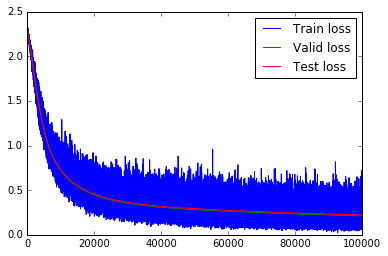

In [9]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

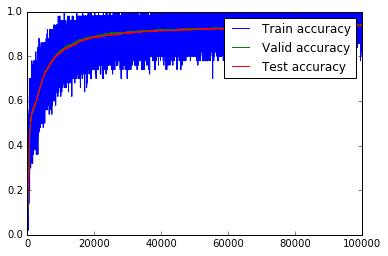

In [10]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()